## Introduction
Promotion is a key milestone in an employee’s career and it affects one’s morale, salary and career path. Although thousands of employees are eligible for each promotion cycle in large companies, 67% of employees in 2024 viewed performance evaluations as unfair and say they do not trust the fairness of the process. This creates mistrust in the system.

Promotion is an important motivating factor for employees to strive to work harder and more efficiently to attain promotions for higher salaries. Knowing which factors affect their chances of being promoted can be greatly beneficial for employees to understand what they need to work towards to increase their chances of getting promoted.

In addition, it can be difficult for HR to keep track of their thousands of employees and note who should be deserving of a promotion. This can lead to conflicts between employees and create tension when they feel that they should have been promoted instead of another colleague.

#### Thus, we wish to investigate whether it may be possible to create a model that accurately predicts whether a person from a certain department will be promoted depending on certain aspects using the Employee Promotion Data found on Kaggle. Such a model will allow for HR teams to correctly identify who they should be promoting, and will also enable employees to understand which aspects they should improve on to strive for their promotion.

Dataset: https://www.kaggle.com/datasets/arashnic/hr-ana?select=train.csv

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import time
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from catboost import CatBoostClassifier
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.patches as mpatches
from scipy.stats import randint

## Exploratory Data Analysis

In [4]:
data = pd.read_csv('train.csv')
dataDF = pd.DataFrame(data)
dataDF

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,0,79,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,45,0


In [5]:
dataDF.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

We assume that different departments may have different criteria for promotion. Thus we have chosen to analyze the top 3 departments.

In [7]:
department = dataDF['department']
department.value_counts()

department
Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: count, dtype: int64

Top 3 departments include: Sales & Marketing, Operations, and Technology.

In [9]:
salesDF = dataDF.loc[dataDF['department'] == 'Sales & Marketing']
operationsDF = dataDF.loc[dataDF['department'] == 'Operations']
technologyDF = dataDF.loc[dataDF['department'] == 'Technology']

## General EDA
The categorical variables seem to be region, education, gender, recruitment_channel, and is_promoted. \
The continuous variables seem to be age, no_of_trainings, length_of_service and avg_training_score. \
The variables previous_year_rating and awards_won? are harder to tell whether they are continous or categorical.

In [11]:
dataDF['previous_year_rating'].value_counts()

previous_year_rating
3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: count, dtype: int64

In [12]:
dataDF['awards_won?'].value_counts()

awards_won?
0    53538
1     1270
Name: count, dtype: int64

previous_year_rating seems to be categorical since it is from a 1 to 5 scale, while awards_won? is also a categorical variable since 1 means that the employee has won awards before while 0 means that they have not won any awards.

Categorical: region, education, gender, recruitment_channel, previous_year_rating, awards_won?, is_promoted. \
Continuous: age, no_of_trainings, length_of_service, avg_training_score.

In [15]:
dataDF['previous_year_rating'] = dataDF['previous_year_rating'].astype(str)

## Sales & Marketing EDA

In [17]:
salesDF

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50,0
9,28911,Sales & Marketing,region_1,Master's & above,m,sourcing,1,32,5.0,5,0,54,0
11,49017,Sales & Marketing,region_7,Bachelor's,f,sourcing,1,35,5.0,3,0,50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54796,12592,Sales & Marketing,region_25,Master's & above,m,other,1,34,3.0,7,0,60,1
54797,62450,Sales & Marketing,region_11,Bachelor's,m,sourcing,1,28,5.0,3,1,47,0
54798,40257,Sales & Marketing,region_2,Master's & above,f,other,2,40,5.0,4,0,51,0
54802,6915,Sales & Marketing,region_14,Bachelor's,m,other,2,31,1.0,2,0,49,0


### Categorical EDA

In [19]:
categorical_vars = ["previous_year_rating", "education", "gender", "recruitment_channel","awards_won?","region"]
salesDF[categorical_vars]

,previous_year_rating,education,gender,recruitment_channel,awards_won?,region
0,5.0,Master's & above,f,sourcing,0,region_7
2,3.0,Bachelor's,m,sourcing,0,region_19
3,1.0,Bachelor's,m,other,0,region_23
9,5.0,Master's & above,m,sourcing,0,region_1
11,5.0,Bachelor's,f,sourcing,0,region_7
...,...,...,...,...,...,...
54796,3.0,Master's & above,m,other,0,region_25
54797,5.0,Bachelor's,m,sourcing,1,region_11
54798,5.0,Master's & above,f,other,0,region_2
54802,1.0,Bachelor's,m,other,0,region_14


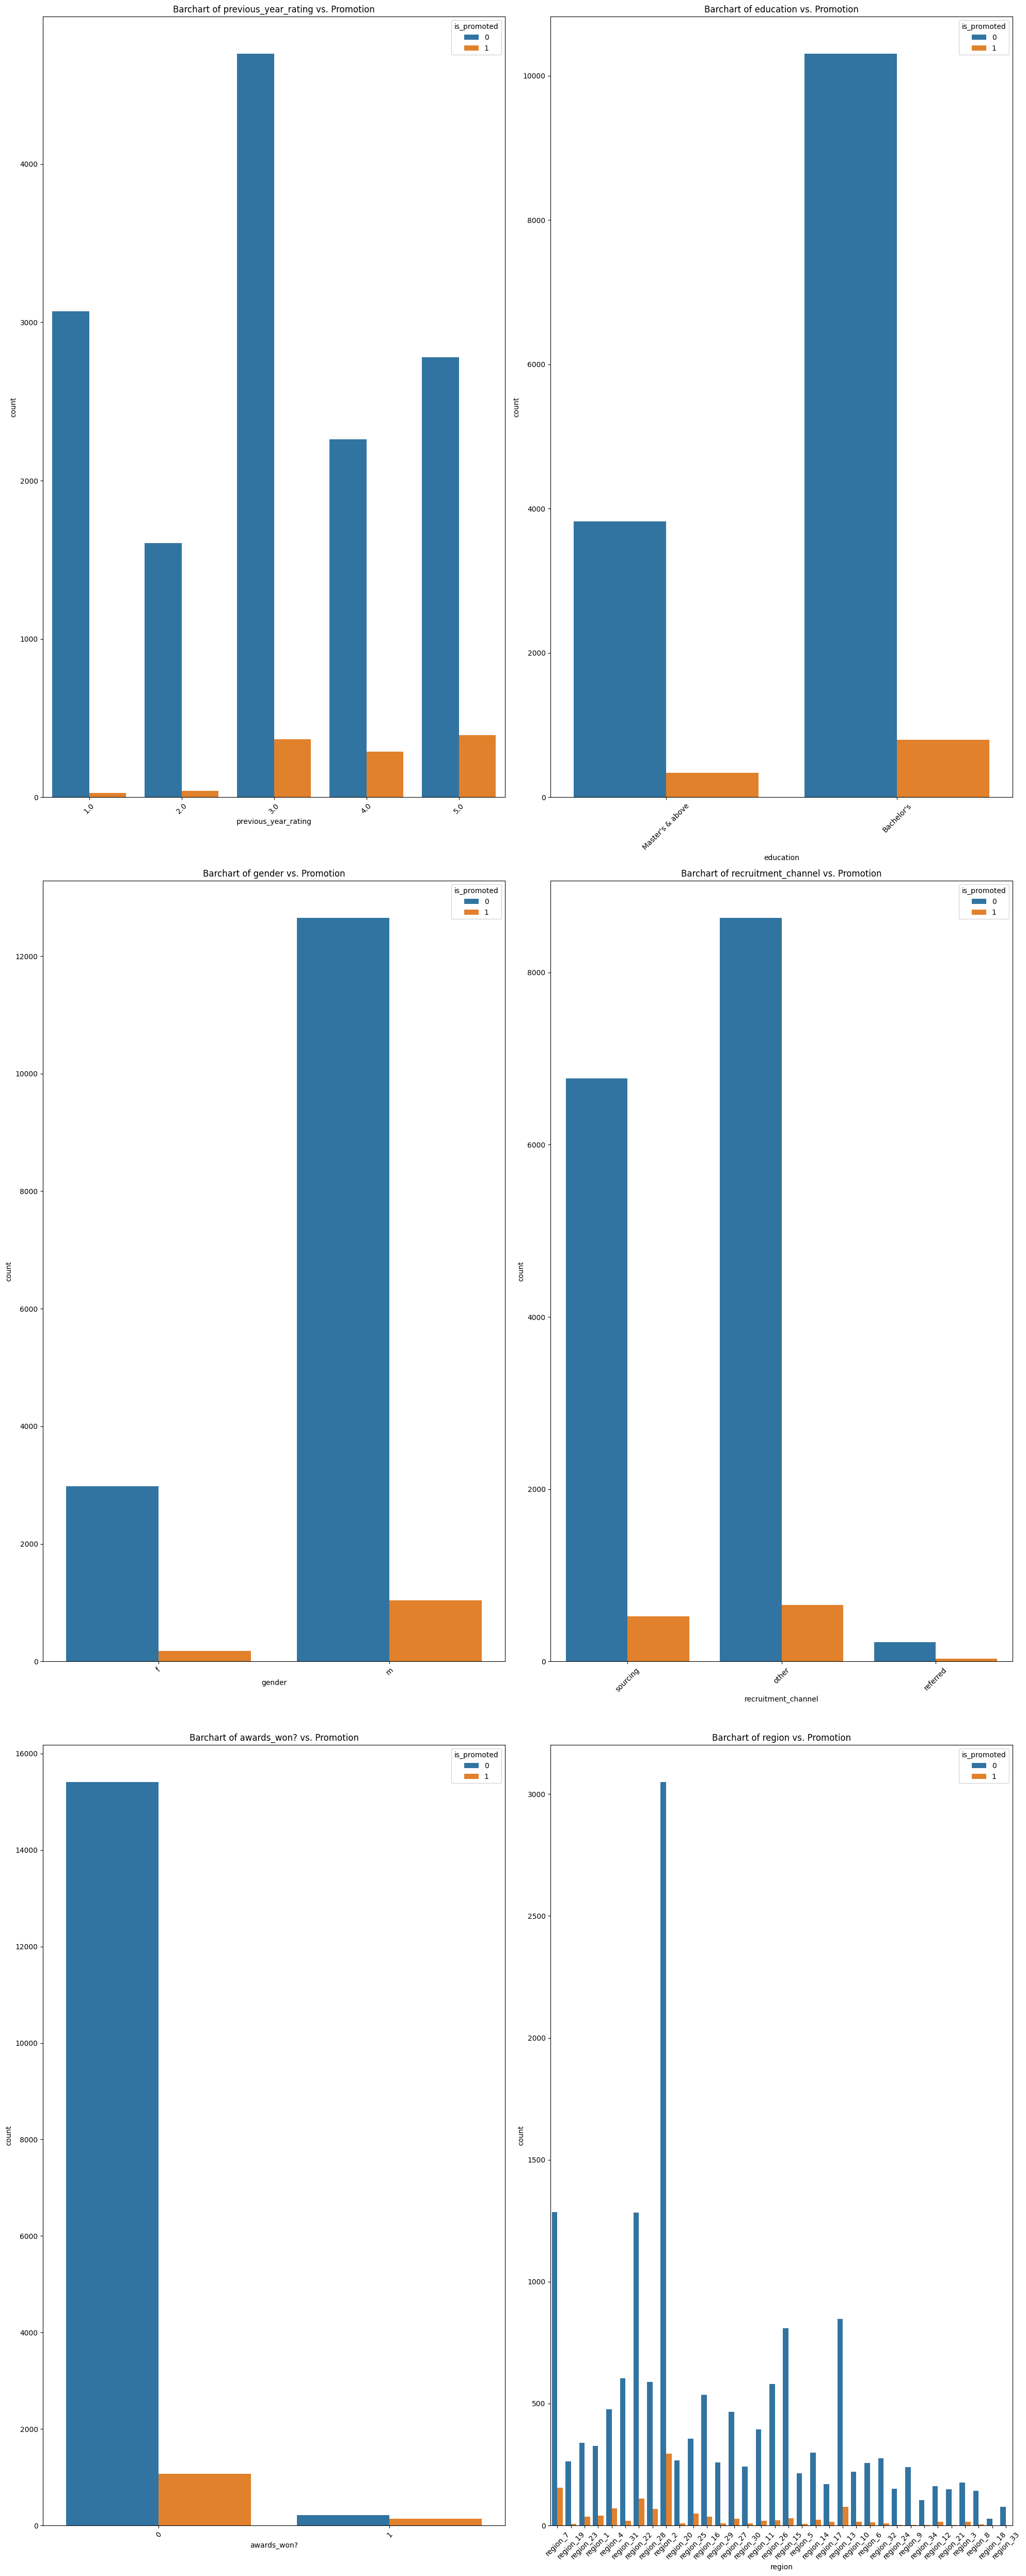

In [20]:
plt.figure(figsize=(20, 50))

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=salesDF, x=var, hue="is_promoted")
    plt.xticks(rotation=45)
    plt.title(f"Barchart of {var} vs. Promotion")

plt.tight_layout()
plt.show()

The bar plot may be slightly difficult to see the relationship between each variable and promotion. Thus, we choose to visualise the relationship using a mosaic plot to better understand the relationship.

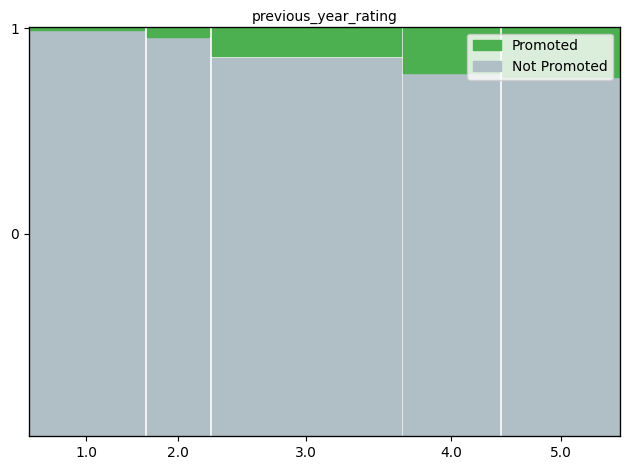

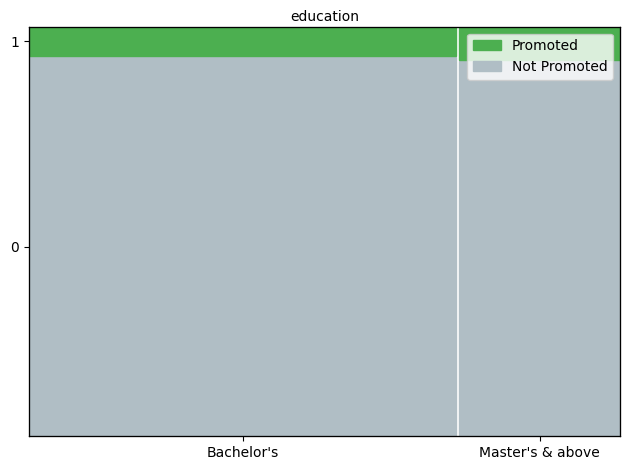

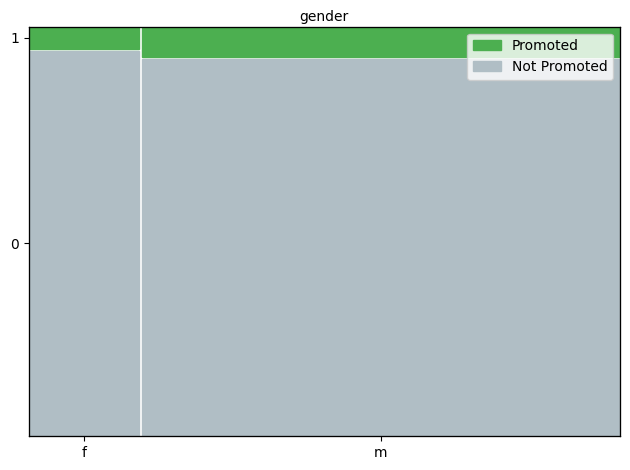

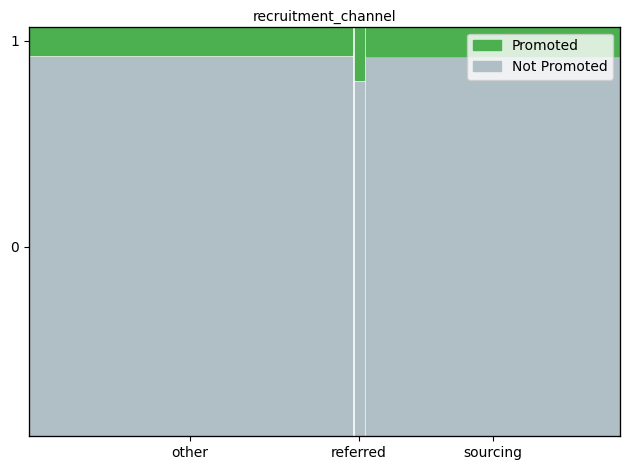

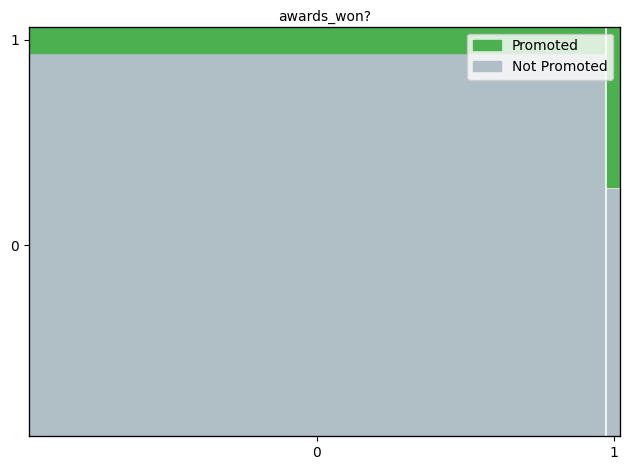

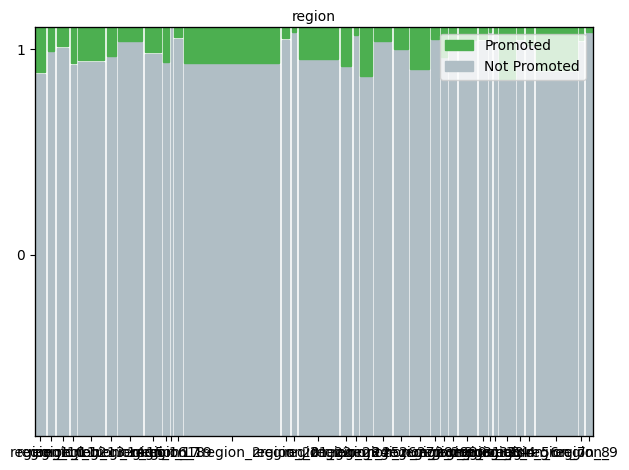

In [22]:
for i in categorical_vars:
    
    crosstable=pd.crosstab(salesDF[i], salesDF['is_promoted'])
    mosaic_data = {(row, col): crosstable.loc[row, col] 
               for row in crosstable.index 
                 for col in crosstable.columns}
    def props(key):
        return {'color': '#4CAF50'} if key[1] == '1' else {'color':'#B0BEC5'}
    

    fig, _ = mosaic(
        mosaic_data,
        properties=props,
        labelizer=lambda k: ''
    )
    yes_patch = mpatches.Patch(color='#4CAF50', label='Promoted')
    no_patch = mpatches.Patch(color='#B0BEC5', label='Not Promoted')
    plt.legend(handles=[yes_patch, no_patch], loc='upper right')

    plt.xlabel(i)
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()

Using the mosaic plot, it can be seen that previous_year_rating and awards_won? seem to have a greater relationship with promotion. We confirm our findings by using Cramer's V values.

#### Cramér's V values
- Measures the strength of association between two categorical variables.

Values range from 0 (no association) to 1 (perfect association)
- Closer to 0 → very weak or no association
- ~0.1 to 0.3 → small to moderate association
- more than 0.3 → strong association

In [25]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

cramers_v(salesDF['previous_year_rating'], salesDF['is_promoted'])


print("Cramér's V values with is_promoted:\n")
for col in categorical_vars:
    v = cramers_v(salesDF[col], salesDF['is_promoted'])
    print(f"{col:<25}: {v:.4f}")

Cramér's V values with is_promoted:

previous_year_rating     : 0.1670
education                : 0.0176
gender                   : 0.0298
recruitment_channel      : 0.0287
awards_won?              : 0.1832
region                   : 0.1200


It seems that previous_year_rating, awards_won? and region have the highest association with is_promoted, and will be more useful for training the model.

### Continuous EDA 
#### Box plot to visualise numerical data sets

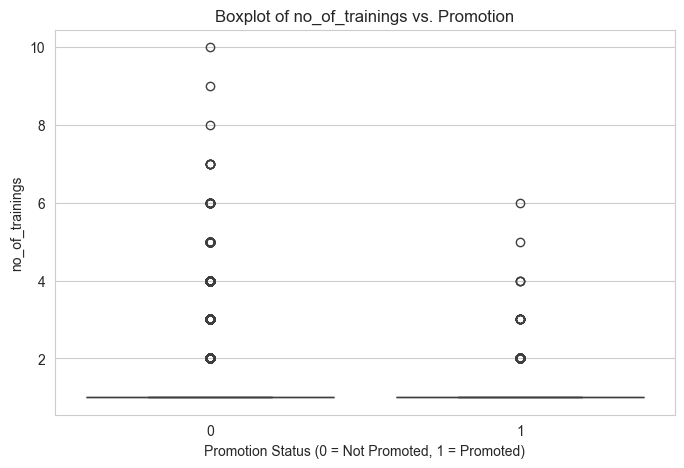

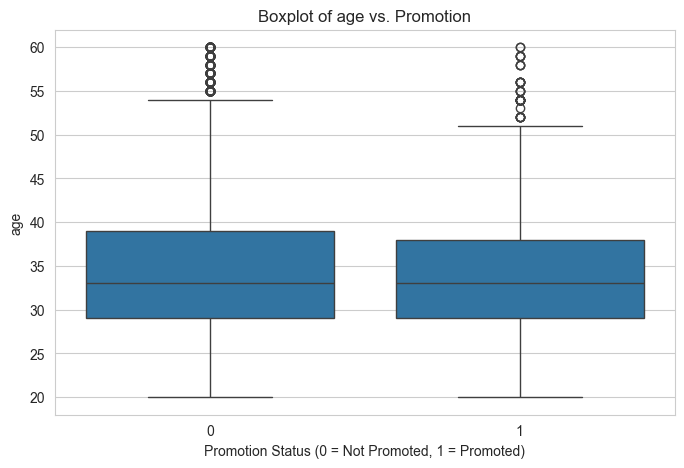

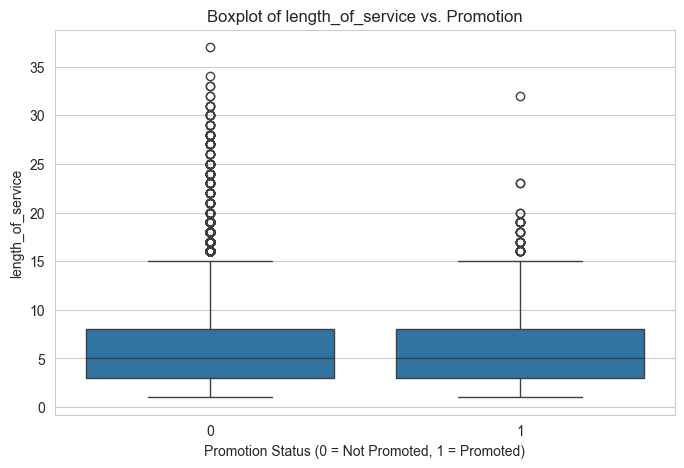

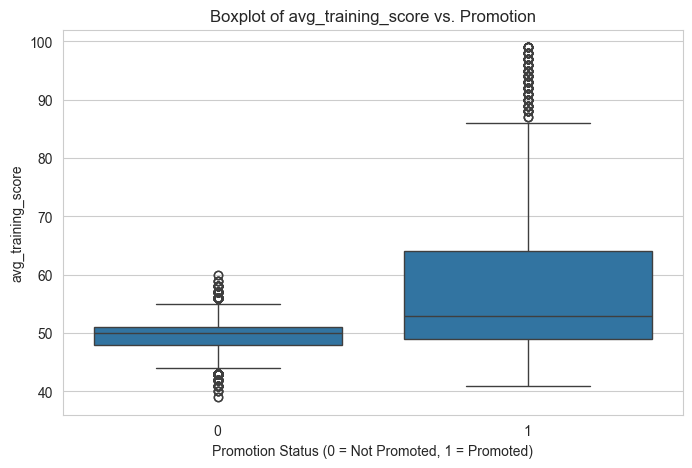

<Figure size 640x480 with 0 Axes>

In [28]:
sns.set_style("whitegrid") 

numerical_features = ["no_of_trainings", "age", "length_of_service", "avg_training_score"]

for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=salesDF["is_promoted"], y=salesDF[col], data=salesDF)
    plt.title(f'Boxplot of {col} vs. Promotion')
    plt.xlabel('Promotion Status (0 = Not Promoted, 1 = Promoted)')
    plt.ylabel(col)
    plt.show() 

plt.tight_layout() 
plt.show()

Box plot shows that only avg_training_score seems to be somewhat correlated to promotion where a higher number correlates to a higher chance of being promoted, while the rest is not obvious.

##### The relationship between no_of_trainings and is_promoted is not visible from box plot above, so we plot a violin plot instead

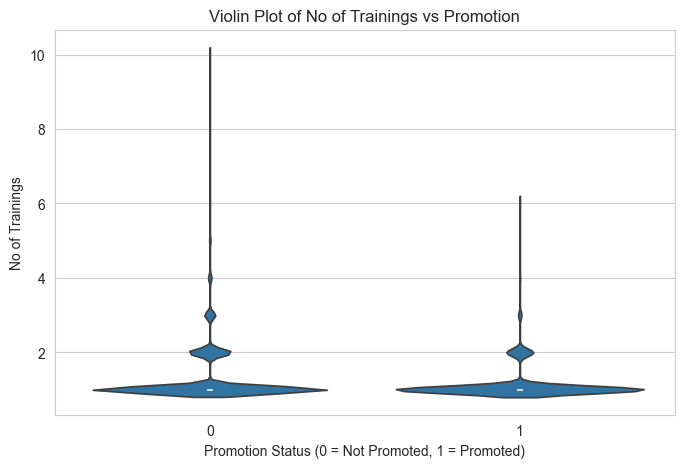

In [31]:
plt.figure(figsize=(8, 5))
sns.violinplot(x="is_promoted", y="no_of_trainings", data=salesDF)
plt.title('Violin Plot of No of Trainings vs Promotion')
plt.xlabel('Promotion Status (0 = Not Promoted, 1 = Promoted)')
plt.ylabel('No of Trainings')
plt.show()

In [32]:
contDF = salesDF[["no_of_trainings", "age", "length_of_service", "avg_training_score","is_promoted"]]
contDF.corr()

,no_of_trainings,age,length_of_service,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.086411,-0.053495,-0.036891,-0.060670
age,-0.086411,1.000000,0.653224,-0.006607,-0.013302
length_of_service,-0.053495,0.653224,1.000000,-0.017075,-0.015709
avg_training_score,-0.036891,-0.006607,-0.017075,1.000000,0.485355
is_promoted,-0.060670,-0.013302,-0.015709,0.485355,1.000000


<Axes: >

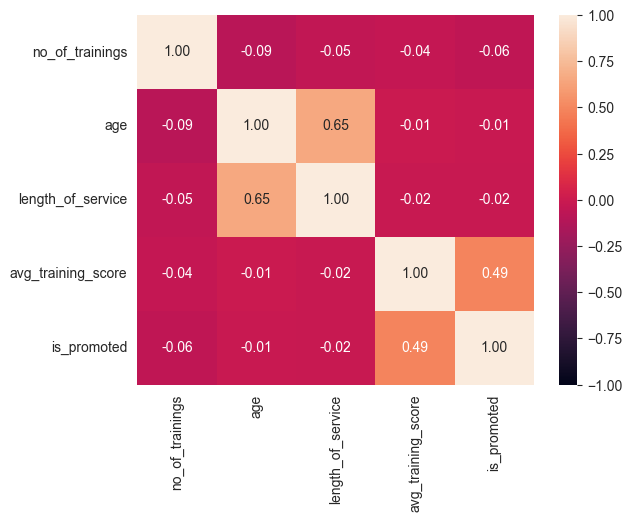

In [33]:
sb.heatmap(contDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

Only avg_training_score seems to have a decent correlation with is_promoted, and thus it will be useful for training the model. \
Chosen categorical variables: previous_year_rating, awards_won? and region \
Chosen continuous variables: avg_training_score

## Operations EDA

In [36]:
operationsDF

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0
6,20379,Operations,region_20,Bachelor's,f,other,1,31,3.0,5,0,59,0
7,16290,Operations,region_34,Master's & above,m,sourcing,1,33,3.0,6,0,63,0
15,43931,Operations,region_7,Bachelor's,m,other,1,37,1.0,10,0,60,0
19,54461,Operations,region_15,Bachelor's,m,other,1,37,3.0,9,0,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54775,31184,Operations,region_22,Bachelor's,m,other,1,30,1.0,4,0,60,0
54780,73767,Operations,region_19,Bachelor's,f,sourcing,1,39,5.0,7,0,60,0
54782,17281,Operations,region_2,Below Secondary,m,sourcing,2,26,3.0,2,0,60,0
54794,35000,Operations,region_16,Bachelor's,m,other,1,37,4.0,7,0,54,0


### Categorical EDA

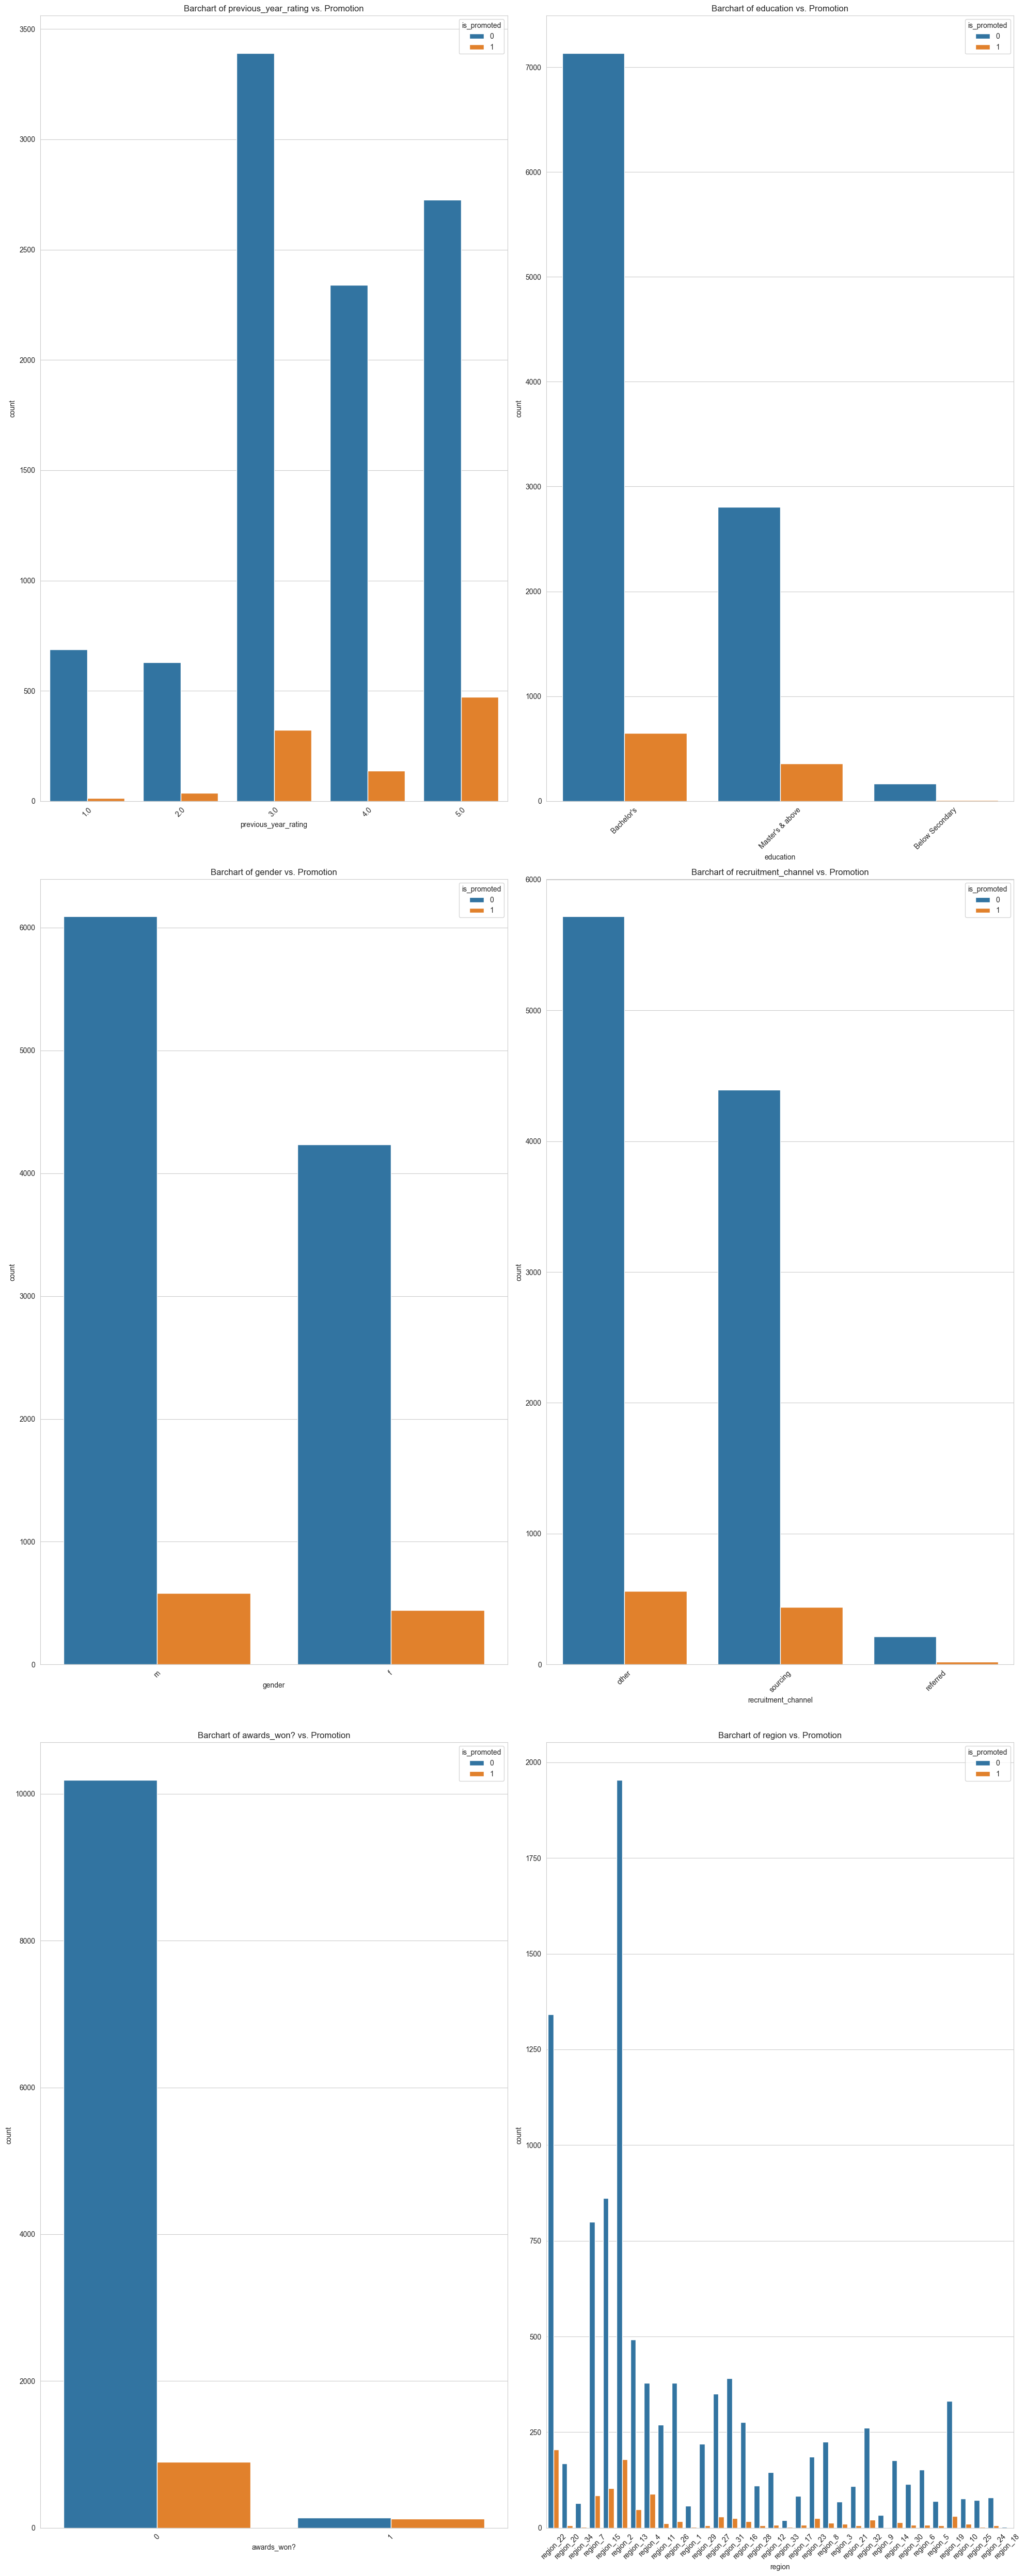

In [38]:
plt.figure(figsize=(20, 50))

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=operationsDF, x=var, hue="is_promoted")
    plt.xticks(rotation=45)
    plt.title(f"Barchart of {var} vs. Promotion")

plt.tight_layout()
plt.show()

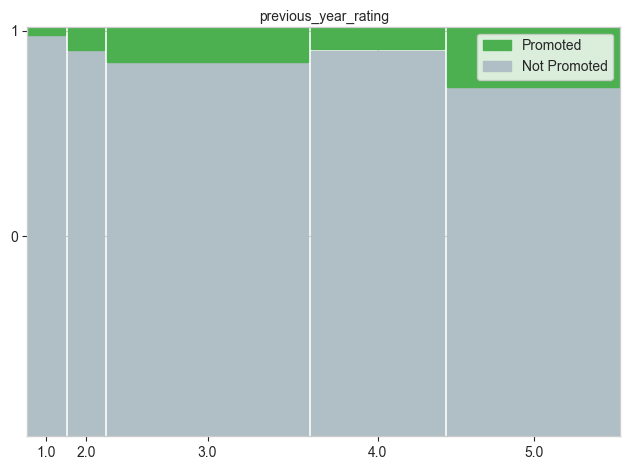

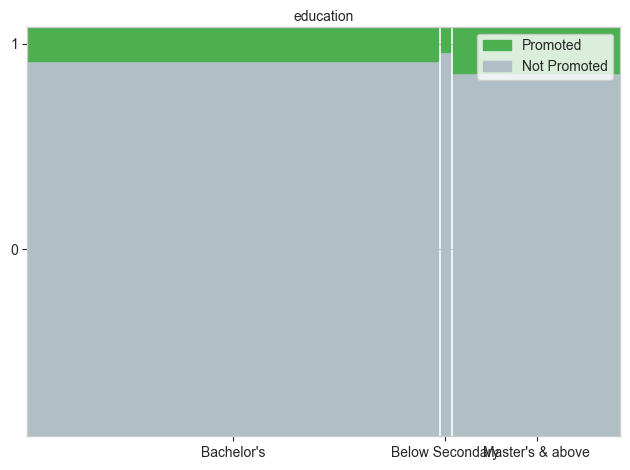

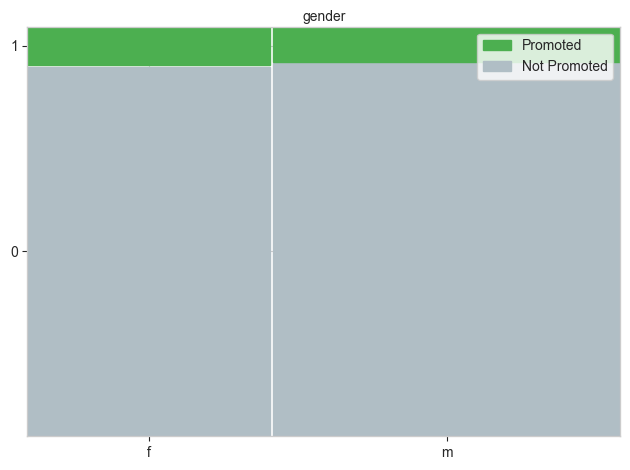

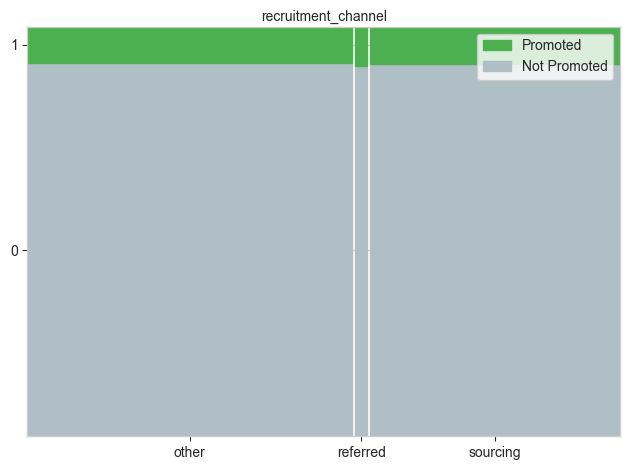

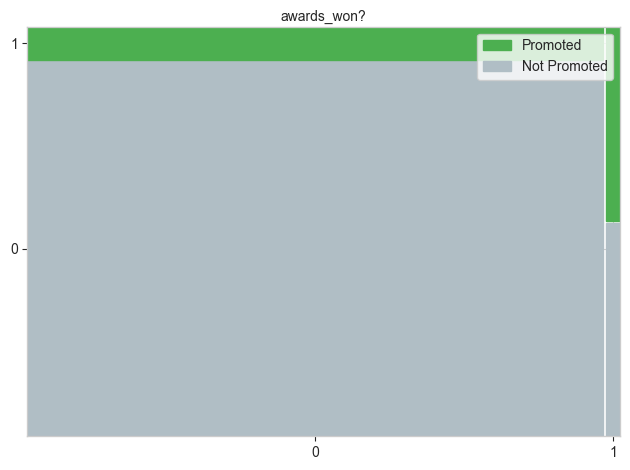

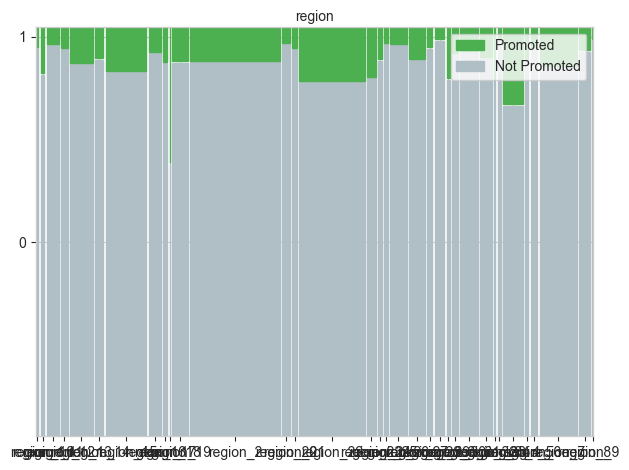

In [39]:
for i in categorical_vars:
    
    crosstable=pd.crosstab(operationsDF[i], operationsDF['is_promoted'])
    mosaic_data = {(row, col): crosstable.loc[row, col] 
               for row in crosstable.index 
                 for col in crosstable.columns}
    def props(key):
        return {'color': '#4CAF50'} if key[1] == '1' else {'color':'#B0BEC5'}
    

    fig, _ = mosaic(
        mosaic_data,
        properties=props,
        labelizer=lambda k: ''
    )
    yes_patch = mpatches.Patch(color='#4CAF50', label='Promoted')
    no_patch = mpatches.Patch(color='#B0BEC5', label='Not Promoted')
    plt.legend(handles=[yes_patch, no_patch], loc='upper right')

    plt.xlabel(i)
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()

previous_year_rating, awards_won? and region seem to show some relationship with promotion. We further confirm it using Cramer's V values.

In [41]:
cramers_v(operationsDF['previous_year_rating'], operationsDF['is_promoted'])


print("Cramér's V values with is_promoted:\n")
for col in categorical_vars:
    v = cramers_v(operationsDF[col], operationsDF['is_promoted'])
    print(f"{col:<25}: {v:.4f}")

Cramér's V values with is_promoted:

previous_year_rating     : 0.1411
education                : 0.0485
gender                   : 0.0124
recruitment_channel      : 0.0039
awards_won?              : 0.2067
region                   : 0.1219


It seems that awards_won? , previous_year_rating and region have the highest association with is_promoted, and will be more useful for training the model.

### Continuous EDA 
#### Box plot to visualise numerical data sets

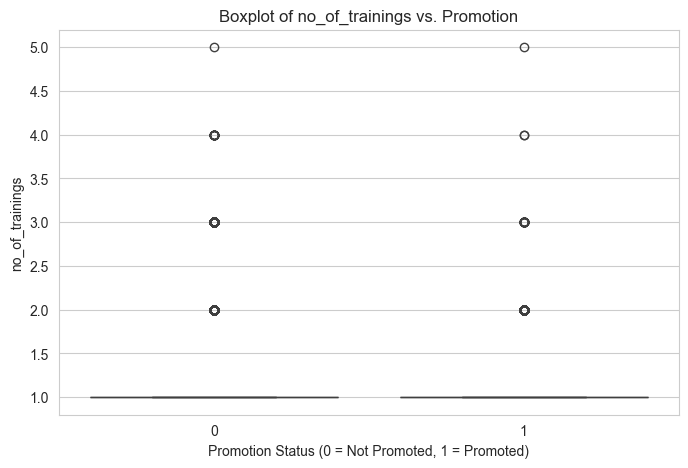

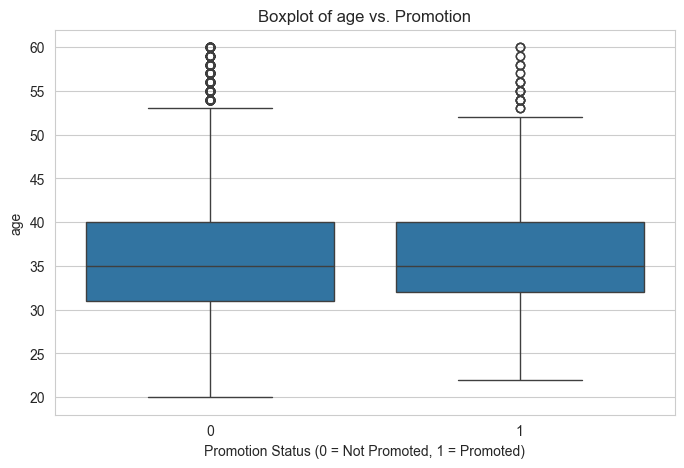

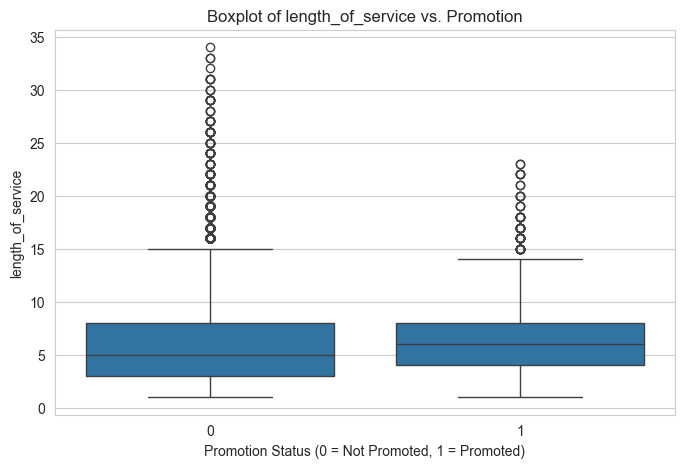

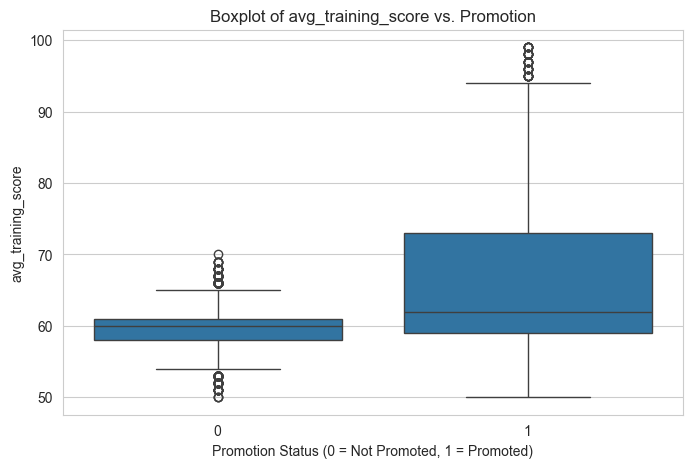

<Figure size 640x480 with 0 Axes>

In [44]:
sns.set_style("whitegrid") 

for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=operationsDF["is_promoted"], y=operationsDF[col], data=operationsDF)
    plt.title(f'Boxplot of {col} vs. Promotion')
    plt.xlabel('Promotion Status (0 = Not Promoted, 1 = Promoted)')
    plt.ylabel(col)
    plt.show() 

plt.tight_layout() 
plt.show()

Box plot shows that only avg_training_score seems to be more strongly positively correlated to promotion, while for the rest is not obvious.

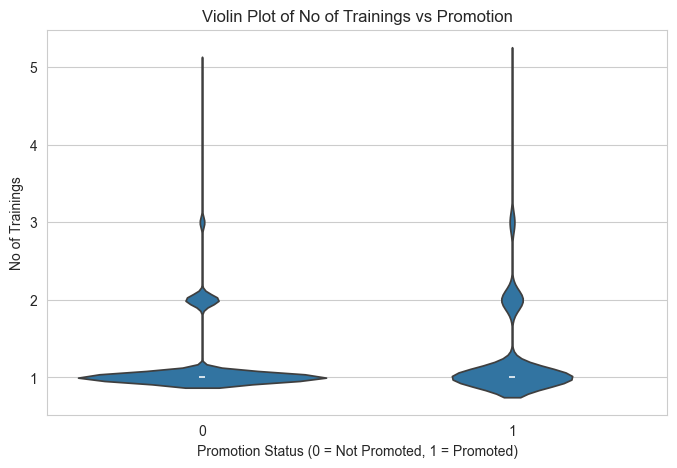

In [46]:
plt.figure(figsize=(8, 5))
sns.violinplot(x="is_promoted", y="no_of_trainings", data=operationsDF)
plt.title('Violin Plot of No of Trainings vs Promotion')
plt.xlabel('Promotion Status (0 = Not Promoted, 1 = Promoted)')
plt.ylabel('No of Trainings')
plt.show()

In [47]:
contDF = operationsDF[["no_of_trainings", "age", "length_of_service", "avg_training_score","is_promoted"]]
contDF.corr()

,no_of_trainings,age,length_of_service,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.055069,-0.033504,0.018226,0.043493
age,-0.055069,1.000000,0.626715,0.025140,0.013982
length_of_service,-0.033504,0.626715,1.000000,0.024048,0.013368
avg_training_score,0.018226,0.025140,0.024048,1.000000,0.457027
is_promoted,0.043493,0.013982,0.013368,0.457027,1.000000


<Axes: >

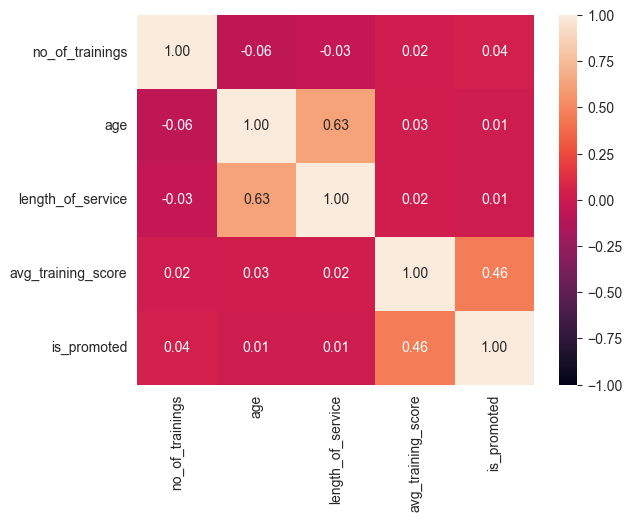

In [48]:
sb.heatmap(contDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

Only avg_training_score seems to have a decent correlation with is_promoted, and thus it will be useful for training the model. \
Chosen categorical variables: previous_year_rating, awards_won? and region \
Chosen continuous variables: avg_training_score

## Technology EDA

In [51]:
technologyDF

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73,0
10,29934,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,77,0
13,38401,Technology,region_29,Master's & above,m,other,2,39,3.0,16,0,80,0
16,7152,Technology,region_2,Bachelor's,m,other,1,38,3.0,5,0,77,0
25,26585,Technology,region_22,Bachelor's,m,other,1,27,5.0,3,0,83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54787,77455,Technology,region_27,Bachelor's,m,sourcing,4,26,3.0,3,0,84,0
54791,27274,Technology,region_11,Bachelor's,m,sourcing,1,32,1.0,3,0,82,0
54793,28400,Technology,region_2,Bachelor's,m,other,1,33,1.0,9,0,79,0
54801,12431,Technology,region_26,Bachelor's,f,sourcing,1,31,NaN,1,0,78,0


### Categorical EDA

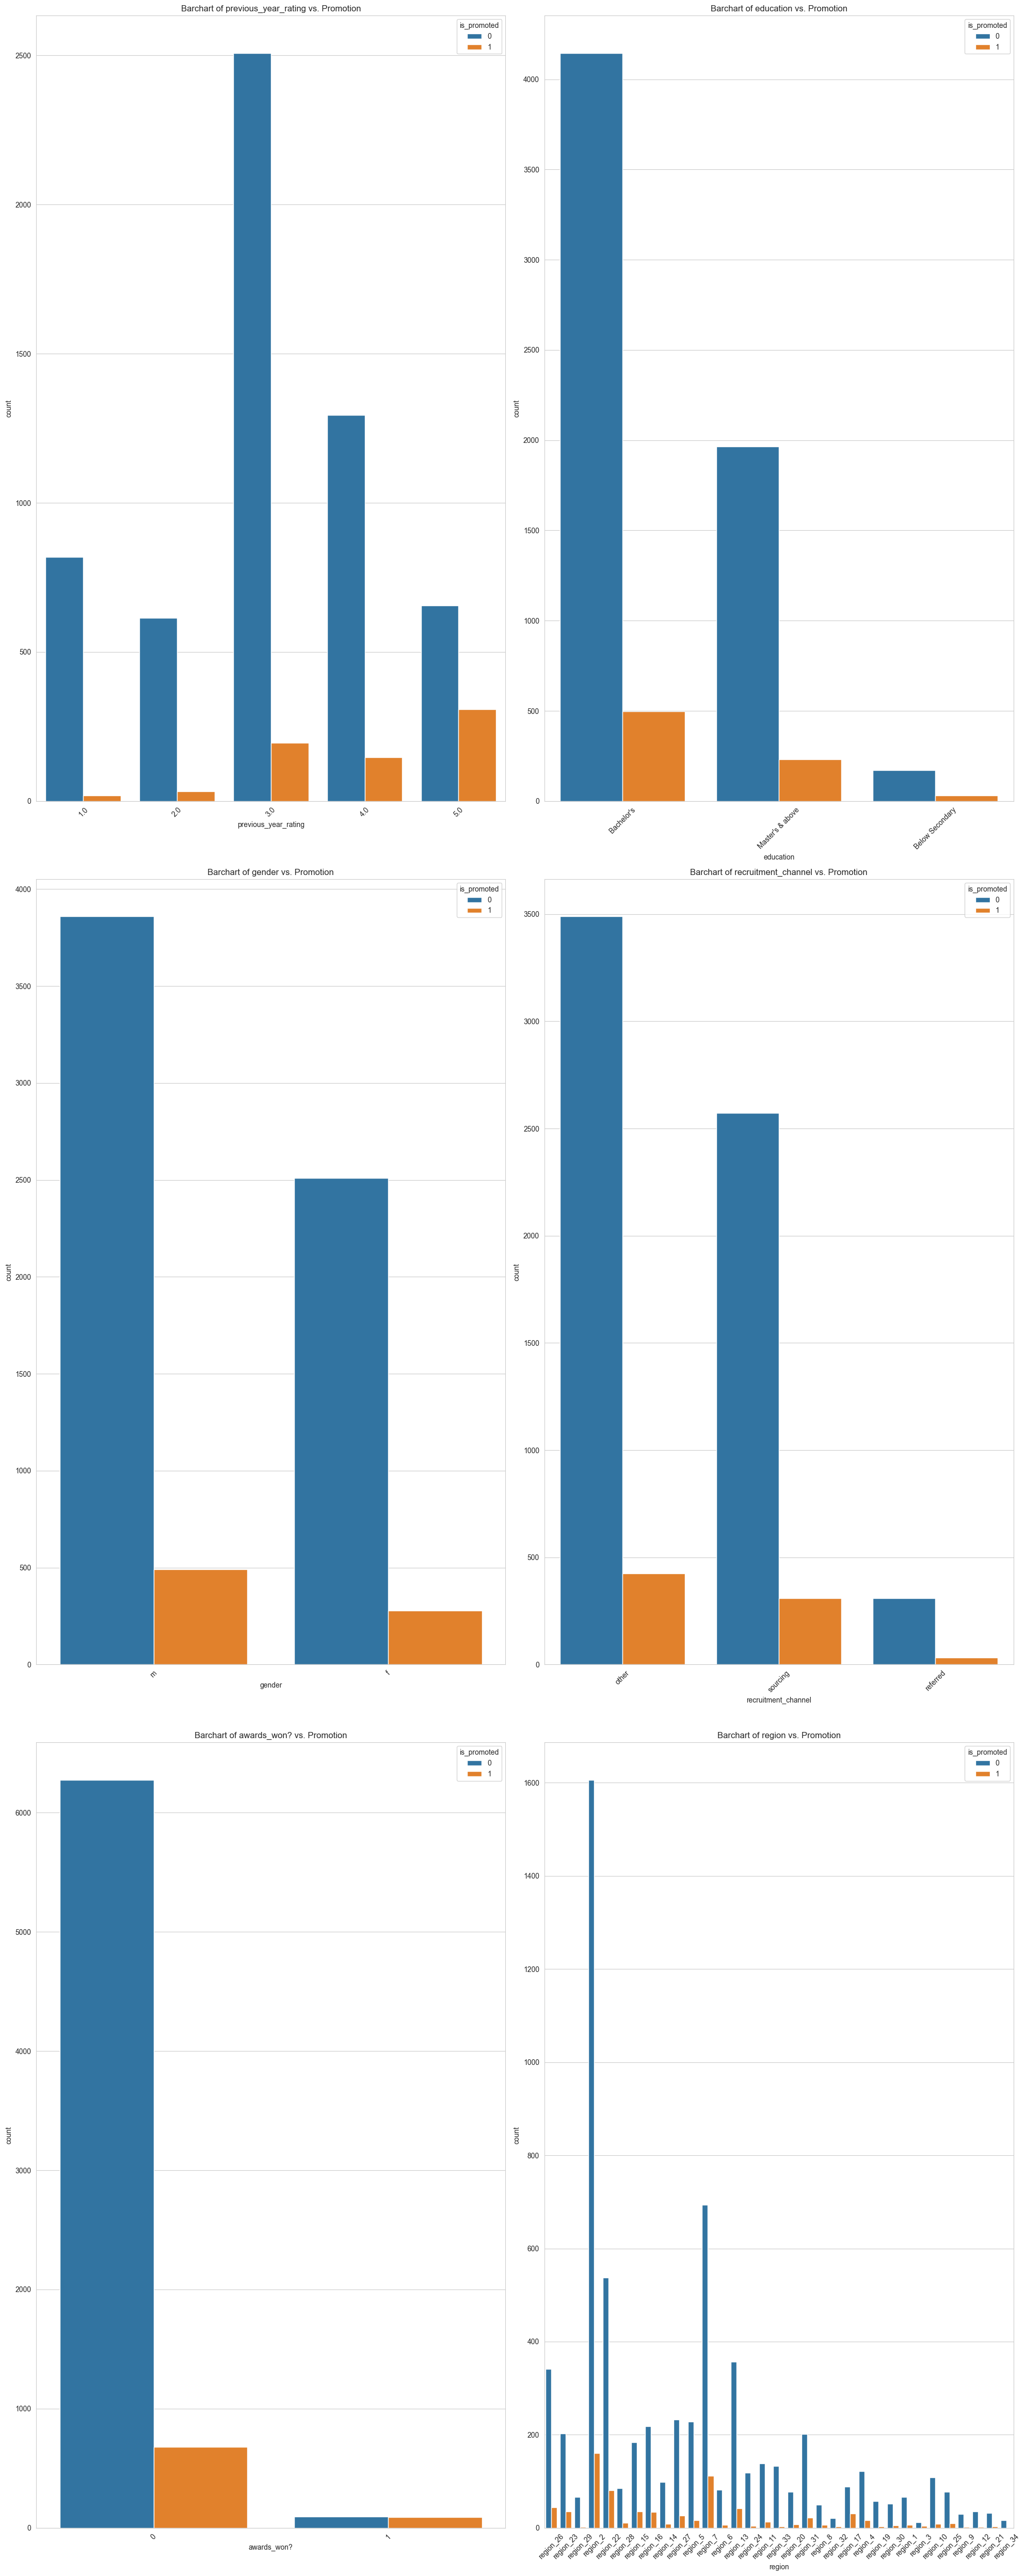

In [53]:
plt.figure(figsize=(20, 50))

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=technologyDF, x=var, hue="is_promoted")
    plt.xticks(rotation=45)
    plt.title(f"Barchart of {var} vs. Promotion")

plt.tight_layout()
plt.show()

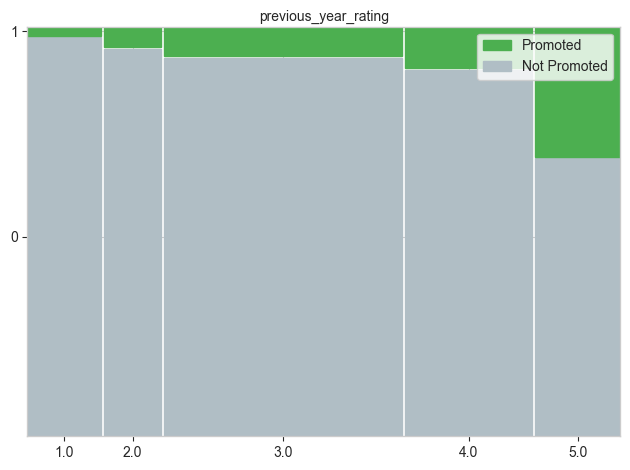

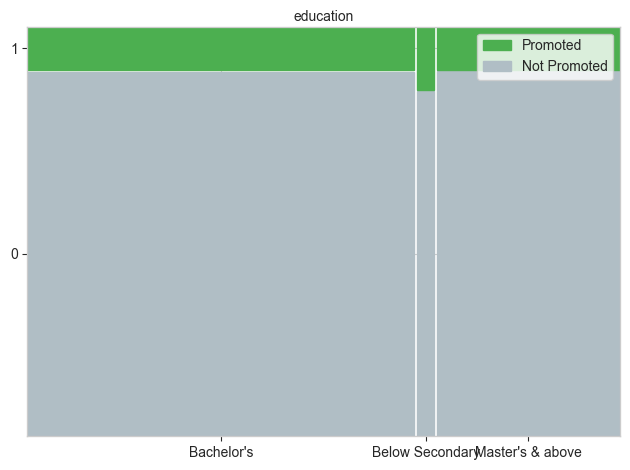

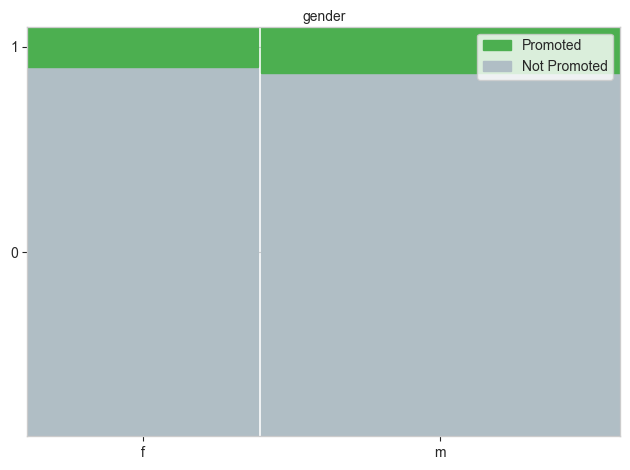

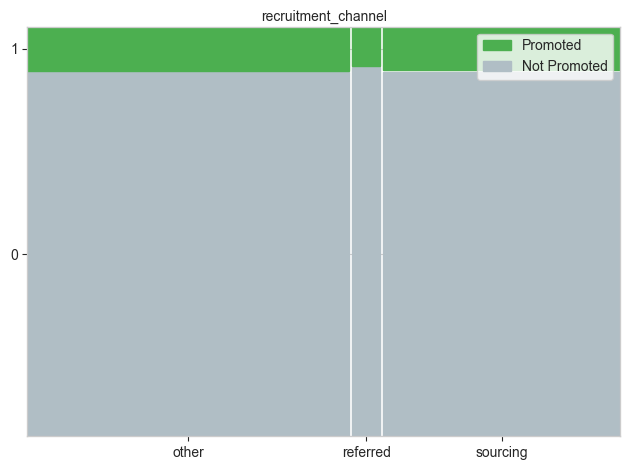

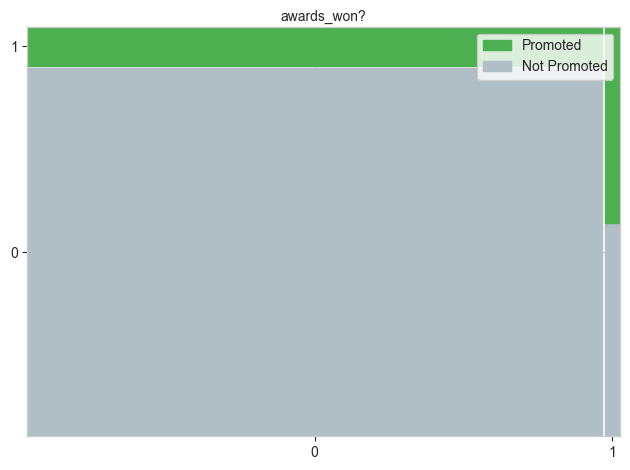

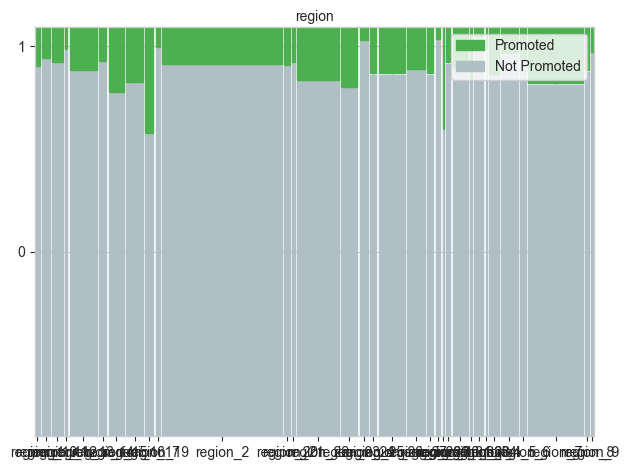

In [54]:
for i in categorical_vars:
    
    crosstable=pd.crosstab(technologyDF[i], technologyDF['is_promoted'])
    mosaic_data = {(row, col): crosstable.loc[row, col] 
               for row in crosstable.index 
                 for col in crosstable.columns}
    def props(key):
        return {'color': '#4CAF50'} if key[1] == '1' else {'color':'#B0BEC5'}
    

    fig, _ = mosaic(
        mosaic_data,
        properties=props,
        labelizer=lambda k: ''
    )
    yes_patch = mpatches.Patch(color='#4CAF50', label='Promoted')
    no_patch = mpatches.Patch(color='#B0BEC5', label='Not Promoted')
    plt.legend(handles=[yes_patch, no_patch], loc='upper right')

    plt.xlabel(i)
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()

previous_year_rating, awards_won? and region seem to show some relationship with promotion. We confirm this using Cramer's V values.

In [56]:
cramers_v(technologyDF['previous_year_rating'], technologyDF['is_promoted'])


print("Cramér's V values with is_promoted:\n")
for col in categorical_vars:
    v = cramers_v(technologyDF[col], technologyDF['is_promoted'])
    print(f"{col:<25}: {v:.4f}")

Cramér's V values with is_promoted:

previous_year_rating     : 0.2946
education                : 0.0256
gender                   : 0.0208
recruitment_channel      : 0.0082
awards_won?              : 0.1952
region                   : 0.1164


It seems that previous_year_rating, awards_won? and region have the highest association with is_promoted, and will be more useful for training the model. However, unlike the other 2 departments, previous_year_rating seems to have the highest association, followed by awards_won and region.

### Continuous EDA 
#### Box plot to visualise numerical data sets

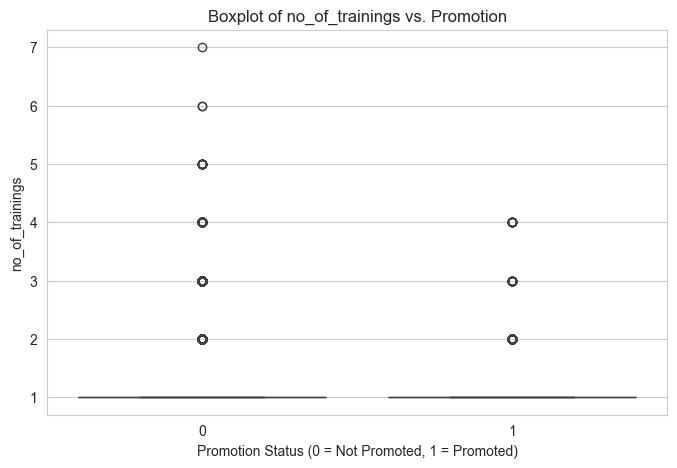

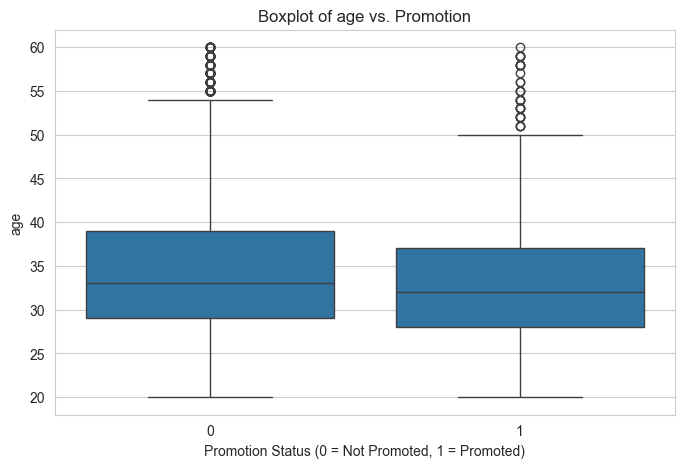

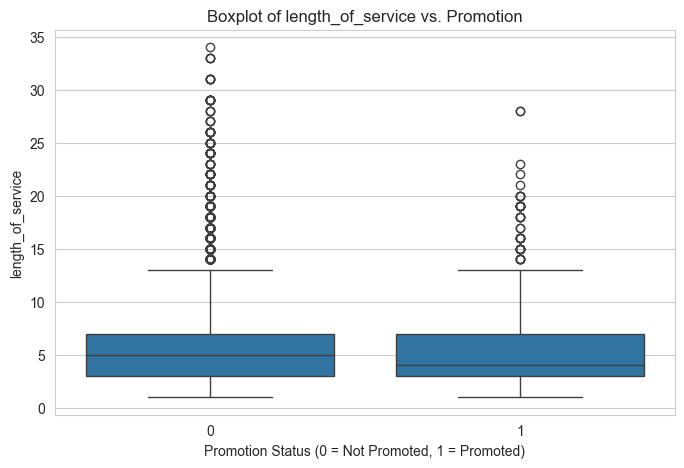

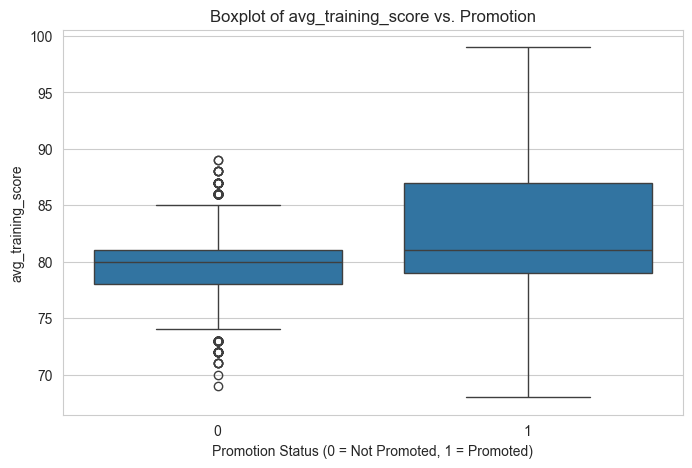

<Figure size 640x480 with 0 Axes>

In [59]:
sns.set_style("whitegrid") 

for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=technologyDF["is_promoted"], y=technologyDF[col], data=technologyDF)
    plt.title(f'Boxplot of {col} vs. Promotion')
    plt.xlabel('Promotion Status (0 = Not Promoted, 1 = Promoted)')
    plt.ylabel(col)
    plt.show() 

plt.tight_layout() 
plt.show()

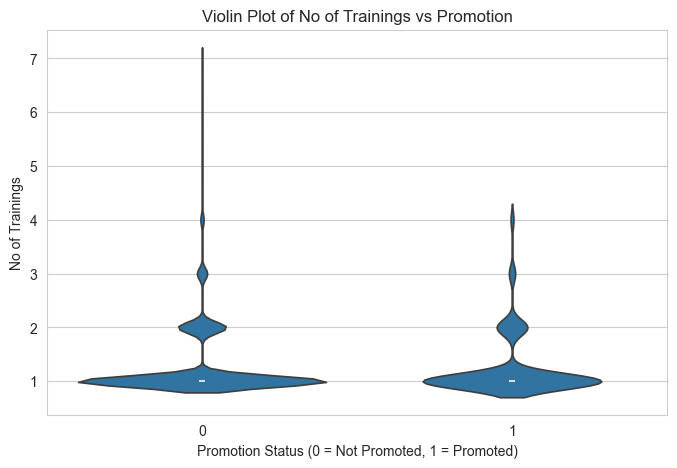

In [60]:
plt.figure(figsize=(8, 5))
sns.violinplot(x="is_promoted", y="no_of_trainings", data=technologyDF)
plt.title('Violin Plot of No of Trainings vs Promotion')
plt.xlabel('Promotion Status (0 = Not Promoted, 1 = Promoted)')
plt.ylabel('No of Trainings')
plt.show()

In [61]:
contDF = technologyDF[["no_of_trainings", "age", "length_of_service", "avg_training_score","is_promoted"]]
contDF.corr()

,no_of_trainings,age,length_of_service,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.099992,-0.070265,0.003277,-0.013909
age,-0.099992,1.000000,0.675570,-0.036443,-0.054324
length_of_service,-0.070265,0.675570,1.000000,-0.020611,-0.033841
avg_training_score,0.003277,-0.036443,-0.020611,1.000000,0.326597
is_promoted,-0.013909,-0.054324,-0.033841,0.326597,1.000000


<Axes: >

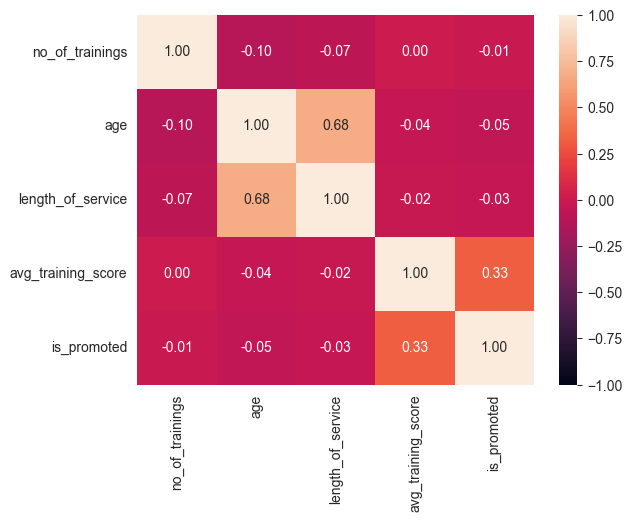

In [62]:
sb.heatmap(contDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

Only avg_training_score seems to have a decent correlation with is_promoted, and thus it will be useful for training the model. \
Chosen categorical variables: previous_year_rating, awards_won? and region \
Chosen continuous variables: avg_training_score

## Data Cleaning

Columns removed: 
- "employee_id" column - unique to each employee so will not affect our analysis
- "department" column - already analyzing the top 3 departments individually
- "education", "gender", "recruitment_channel", "no_of_trainings", "age", "length_of_service" columns - low correlation with is_promoted, and thus will not be useful in the model

In [66]:
dropped = ["employee_id", "education", "gender", "recruitment_channel", "no_of_trainings", "age", "department","length_of_service"]
sales = salesDF.drop(dropped, axis = 1)
ops = operationsDF.drop(dropped, axis = 1)
tech = technologyDF.drop(dropped, axis = 1)

#### Checking for null values

In [68]:
sales.isnull().sum()

region                     0
previous_year_rating    1311
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [69]:
salesDF[salesDF['previous_year_rating'].isna()]

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
29,74759,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,44,0
56,45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,49,0
58,26599,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,0,47,0
67,16502,Sales & Marketing,region_22,Bachelor's,m,sourcing,1,27,NaN,1,0,61,1
89,9589,Sales & Marketing,region_31,Bachelor's,f,other,1,31,NaN,1,0,51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54588,29221,Sales & Marketing,region_28,Bachelor's,m,sourcing,1,30,NaN,1,0,53,0
54611,55808,Sales & Marketing,region_28,Bachelor's,m,other,1,25,NaN,1,0,54,0
54627,19097,Sales & Marketing,region_26,Bachelor's,m,other,1,23,NaN,1,0,51,0
54638,45494,Sales & Marketing,region_19,Bachelor's,m,other,1,29,NaN,1,0,50,0


Previous year rating is not known for 1311 people. We can replace it with 0 instead to represent no rating, since it is a categorical variable.

In [71]:
salesclean = sales.fillna('0')
opsclean = ops.fillna('0')
techclean = tech.fillna('0')

In [72]:
salesclean.isnull().sum()

region                  0
previous_year_rating    0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

In [73]:
opsclean.isnull().sum()

region                  0
previous_year_rating    0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

In [74]:
techclean.isnull().sum()

region                  0
previous_year_rating    0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

previous_year_rating is currently the type float, which will cause issues in the model later on since it is a categorical variable. Thus we change it to the string type.

In [76]:
salesclean['previous_year_rating'] = salesclean['previous_year_rating'].astype(str)
opsclean['previous_year_rating'] = opsclean['previous_year_rating'].astype(str)
techclean['previous_year_rating'] = techclean['previous_year_rating'].astype(str)

## Oversampling (SMOTE-NC)

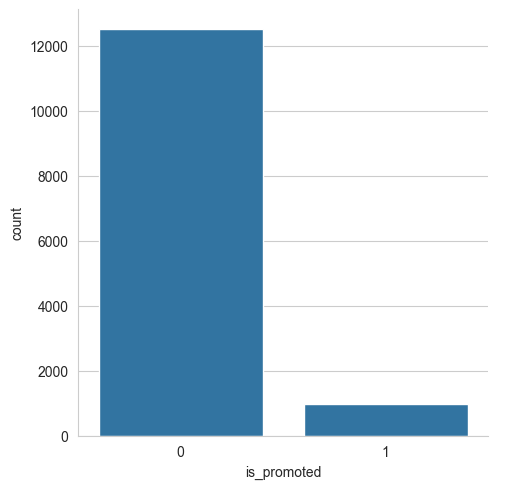

In [78]:
y = pd.DataFrame(salesclean['is_promoted'].astype('category'))
x = pd.DataFrame(salesclean.drop('is_promoted', axis = 1))

X_train_sales, X_test_sales1, y_train_sales, y_test_sales1 = train_test_split(x, y, test_size = 0.20)

sb.catplot(x = "is_promoted", data = y_train_sales, kind = "count")

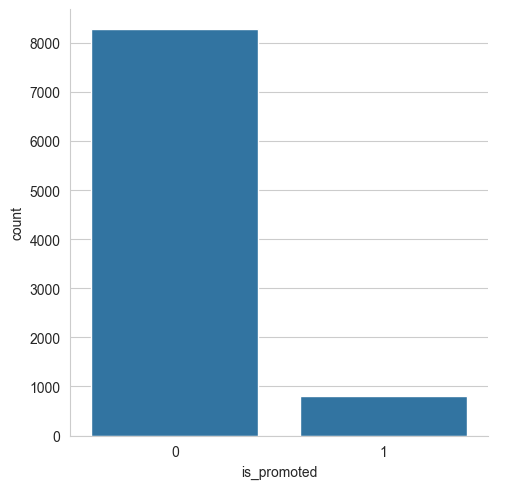

In [79]:
y = pd.DataFrame(opsclean['is_promoted'].astype('category'))
x = pd.DataFrame(opsclean.drop('is_promoted', axis = 1))

X_train_ops, X_test_ops1, y_train_ops, y_test_ops1 = train_test_split(x, y, test_size = 0.20)

sb.catplot(x = "is_promoted", data = y_train_ops, kind = "count")

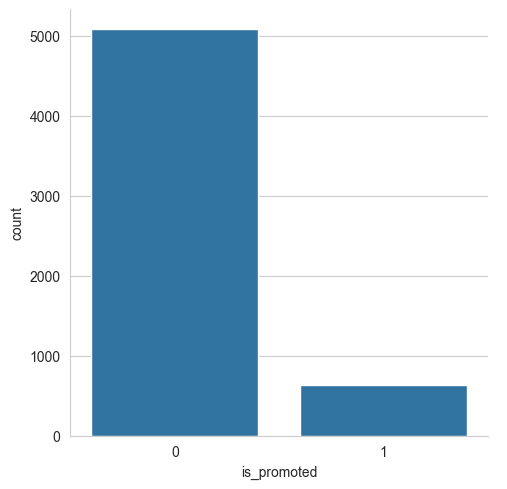

In [80]:
y = pd.DataFrame(techclean['is_promoted'].astype('category'))
x = pd.DataFrame(techclean.drop('is_promoted', axis = 1))

X_train_tech, X_test_tech1, y_train_tech, y_test_tech1 = train_test_split(x, y, test_size = 0.20)

sb.catplot(x = "is_promoted", data = y_train_tech, kind = "count")

All of them seem to be very imbalanced, with a large majority being not promoted. Thus we utilise SMOTE-NC to oversample the training data such that the number of people promoted is equal to the number that is not promoted to improve the accuracy of the models later. The test data set will not be oversampled since it will be an inaccurate depiction of real life scenarios for promotion.

In [82]:
cat_cols = ['previous_year_rating', 'awards_won?', 'region']

smote=SMOTENC(categorical_features = cat_cols) 

X_train_sales1,y_train_sales1 = smote.fit_resample(X_train_sales,y_train_sales)
X_train_ops1,y_train_ops1 = smote.fit_resample(X_train_ops,y_train_ops)
X_train_tech1,y_train_tech1 = smote.fit_resample(X_train_tech,y_train_tech)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sk

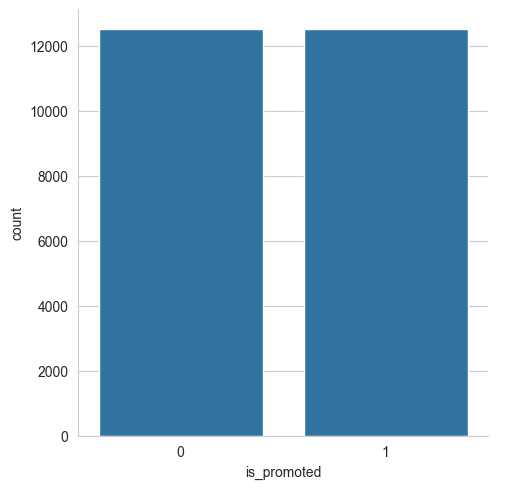

In [83]:
sb.catplot(x = "is_promoted", data = y_train_sales1, kind = "count")

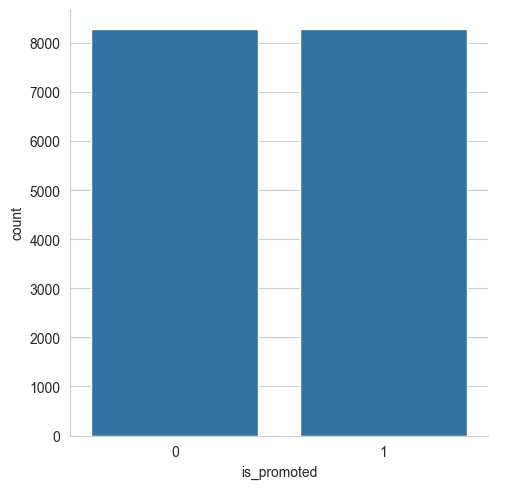

In [84]:
sb.catplot(x = "is_promoted", data = y_train_ops1, kind = "count")

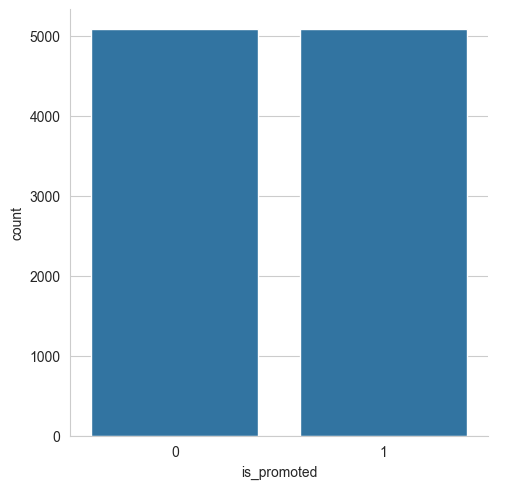

In [85]:
sb.catplot(x = "is_promoted", data = y_train_tech1, kind = "count")

In [86]:
salestraindata = pd.concat([X_train_sales1,y_train_sales1], axis = 1, join = "inner")
salestestdata = pd.concat([X_test_sales1,y_test_sales1], axis = 1)

opstraindata = pd.concat([X_train_ops1,y_train_ops1], axis = 1, join = "inner")
opstestdata = pd.concat([X_test_ops1,y_test_ops1], axis = 1)

techtraindata = pd.concat([X_train_tech1,y_train_tech1], axis = 1, join = "inner")
techtestdata = pd.concat([X_test_tech1,y_test_tech1], axis = 1)

In [87]:
salestraindata['is_promoted'].value_counts()

is_promoted
0    12505
1    12505
Name: count, dtype: int64

In [88]:
opstraindata['is_promoted'].value_counts()

is_promoted
0    8272
1    8272
Name: count, dtype: int64

In [89]:
techtraindata['is_promoted'].value_counts()

is_promoted
0    5079
1    5079
Name: count, dtype: int64

## Encoding
Models such as decision trees and random forest require their categorical variables to be encoded before a model can be created. Thus we utilise target encoding for categorical variables to convert them into numerical values.

#### Target Encoding

In [91]:
encoder = TargetEncoder(cols = cat_cols)
targetencode = encoder.fit_transform(salestraindata[cat_cols], salestraindata['is_promoted'])
salestraindata = pd.concat([salestraindata[['avg_training_score','is_promoted']], targetencode], axis = 1)

targetencode = encoder.fit_transform(opstraindata[cat_cols], opstraindata['is_promoted'])
opstraindata = pd.concat([opstraindata[['avg_training_score','is_promoted']], targetencode], axis = 1)

targetencode = encoder.fit_transform(techtraindata[cat_cols], techtraindata['is_promoted'])
techtraindata = pd.concat([techtraindata[['avg_training_score','is_promoted']], targetencode], axis = 1)

In [92]:
X_train_sales = salestraindata.drop(['is_promoted'], axis = 1)
y_train_sales = salestraindata['is_promoted']

X_train_ops = opstraindata.drop(['is_promoted'], axis = 1)
y_train_ops = opstraindata['is_promoted']

X_train_tech = techtraindata.drop(['is_promoted'], axis = 1)
y_train_tech = techtraindata['is_promoted']

#### Encoding test data for prediction later

In [94]:
targetencode = encoder.fit_transform(salestestdata[cat_cols], salestestdata['is_promoted'])
salestestdata = pd.concat([salestestdata[['avg_training_score','is_promoted']], targetencode], axis = 1)

targetencode = encoder.fit_transform(opstestdata[cat_cols], opstestdata['is_promoted'])
opstestdata = pd.concat([opstestdata[['avg_training_score','is_promoted']], targetencode], axis = 1)

targetencode = encoder.fit_transform(techtestdata[cat_cols], techtestdata['is_promoted'])
techtestdata = pd.concat([techtestdata[['avg_training_score','is_promoted']], targetencode], axis = 1)

In [95]:
X_test_sales = salestestdata.drop(['is_promoted'], axis = 1)
y_test_sales = salestestdata['is_promoted']

X_test_ops = opstestdata.drop(['is_promoted'], axis = 1)
y_test_ops = opstestdata['is_promoted']

X_test_tech = techtestdata.drop(['is_promoted'], axis = 1)
y_test_tech = techtestdata['is_promoted']

## Decision Tree 

#### Sales & Marketing

In [98]:
start = time.time()
dectree1 = DecisionTreeClassifier()
dectree1.fit(X_train_sales, y_train_sales)
end = time.time()


y_train_pred = dectree1.predict(X_train_sales)
y_test_pred = dectree1.predict(X_test_sales)

print("Classification Accuracy for train \t:", dectree1.score(X_train_sales, y_train_sales))
print("Classification Accuracy for test \t:", dectree1.score(X_test_sales, y_test_sales))
score = f1_score(y_test_sales, y_test_pred, average='binary')
print("F1-Score \t:", score)
recall = recall_score(y_test_sales, y_test_pred, average='binary')
print("Recall \t:", recall)
print("Time taken \t:", end-start)

Classification Accuracy for train 	: 0.8305077968812475
Classification Accuracy for test 	: 0.9560570071258907
F1-Score 	: 0.5697674418604651
Recall 	: 0.3983739837398374
Time taken 	: 0.040663719177246094


<Axes: >

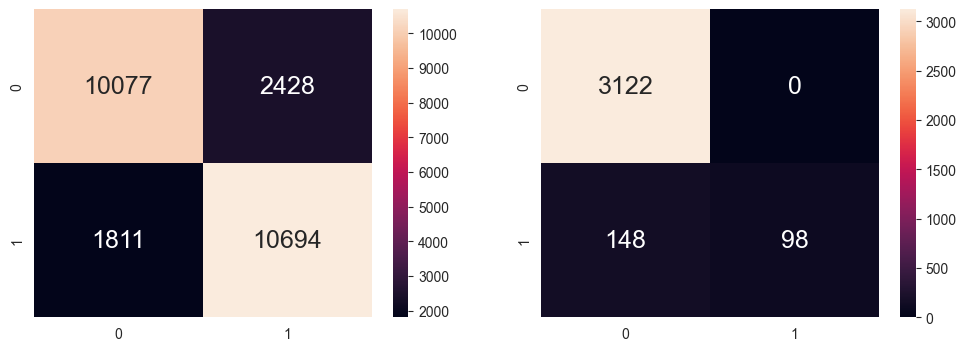

In [99]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_sales, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_sales, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#### Operations

In [101]:
start = time.time()
dectree2 = DecisionTreeClassifier()
dectree2.fit(X_train_ops, y_train_ops)
end = time.time()


y_train_pred = dectree2.predict(X_train_ops)
y_test_pred = dectree2.predict(X_test_ops)

print("Classification Accuracy for train \t:", dectree2.score(X_train_ops, y_train_ops))
print("Classification Accuracy for test \t:", dectree2.score(X_test_ops, y_test_ops))
score = f1_score(y_test_ops, y_test_pred, average='binary')
print("F1-Score \t:", score)
recall = recall_score(y_test_ops, y_test_pred, average='binary')
print("Recall \t:", recall)
print("Time taken \t:", end-start)

Classification Accuracy for train 	: 0.820176499032882
Classification Accuracy for test 	: 0.9356828193832599
F1-Score 	: 0.5290322580645161
Recall 	: 0.3778801843317972
Time taken 	: 0.017371654510498047


<Axes: >

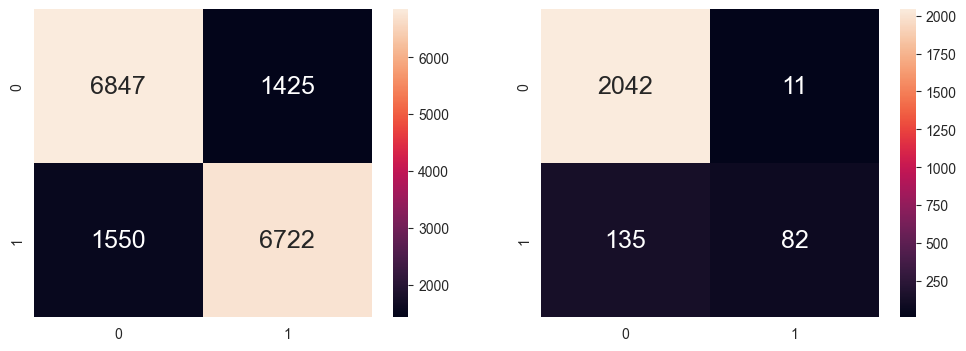

In [102]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_ops, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_ops, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#### Technology

In [104]:
start = time.time()
dectree3 = DecisionTreeClassifier()
dectree3.fit(X_train_tech, y_train_tech)
end = time.time()


y_train_pred = dectree3.predict(X_train_tech)
y_test_pred = dectree3.predict(X_test_tech)

print("Classification Accuracy for train \t:", dectree3.score(X_train_tech, y_train_tech))
print("Classification Accuracy for test \t:", dectree3.score(X_test_tech, y_test_tech))
score = f1_score(y_test_tech, y_test_pred, average='binary')
print("F1-Score \t:", score)
recall = recall_score(y_test_tech, y_test_pred, average='binary')
print("Recall \t:", recall)
print("Time taken \t:", end-start)

Classification Accuracy for train 	: 0.843374680055129
Classification Accuracy for test 	: 0.9173669467787114
F1-Score 	: 0.2976190476190476
Recall 	: 0.18248175182481752
Time taken 	: 0.01192927360534668


<Axes: >

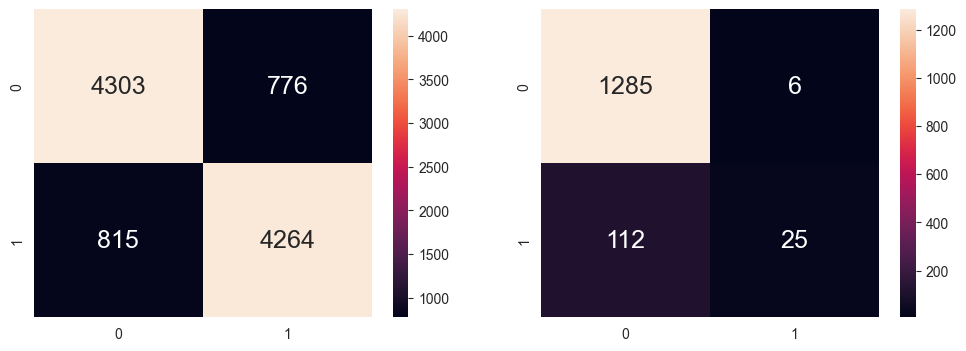

In [105]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_tech, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_tech, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#### Hyperparameter Tuning for Decision Tree using GridSearchCV
Using the code below, we try to find the best hyperparameters for each decision tree to hopefully improve the metrics of each tree.

In [107]:
def DTtuning(X_train,y_train, X_test, y_test):
    dectree = DecisionTreeClassifier()
    param_grid = {
    'max_depth': [3, 5, 10,15,20,23, 25,27, 30],
    'min_samples_split': [2, 5,8, 10,12,15],
    'criterion': ['gini', 'entropy']
}


    grid_search = GridSearchCV(estimator=dectree, param_grid=param_grid, cv=5, scoring='accuracy')

    start = time.time()
    grid_search.fit(X_train, y_train)
    end = time.time()
    print("Time taken to search for hyperparameters: \t", end - start)


    print("Best Hyperparameters:", grid_search.best_params_)


    y_train_pred = grid_search.predict(X_train)
    y_test_pred = grid_search.predict(X_test)

    print("Classification Accuracy for train \t:", grid_search.score(X_train, y_train))
    print("Classification Accuracy for test \t:", grid_search.score(X_test, y_test))
    score = f1_score(y_test, y_test_pred, average='binary')
    print("F1-Score \t:", score)
    recall = recall_score(y_test, y_test_pred, average='binary')
    print("Recall \t:", recall)

    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#### Tuning for Sales & Marketing

Time taken to search for hyperparameters: 	 12.173465967178345
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 12}
Classification Accuracy for train 	: 0.8272690923630548
Classification Accuracy for test 	: 0.9560570071258907
F1-Score 	: 0.5697674418604651
Recall 	: 0.3983739837398374


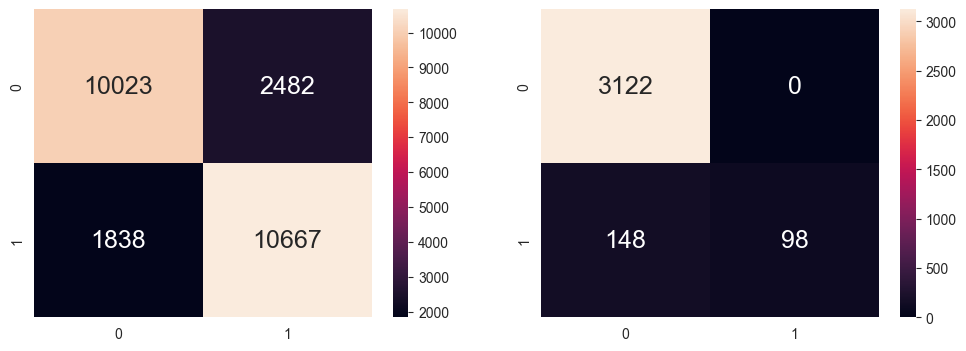

In [109]:
DTtuning(X_train_sales,y_train_sales, X_test_sales, y_test_sales)

#### Tuning for Operations

Time taken to search for hyperparameters: 	 9.230026483535767
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 27, 'min_samples_split': 8}
Classification Accuracy for train 	: 0.8182422630560928
Classification Accuracy for test 	: 0.9405286343612335
F1-Score 	: 0.5484949832775919
Recall 	: 0.3778801843317972


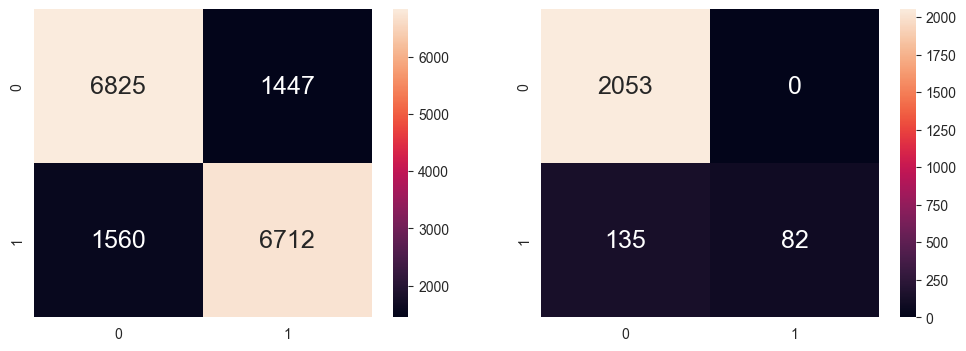

In [111]:
DTtuning(X_train_ops,y_train_ops, X_test_ops, y_test_ops)

#### Tuning for Technology

Time taken to search for hyperparameters: 	 6.773080825805664
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 27, 'min_samples_split': 5}
Classification Accuracy for train 	: 0.8415042331167553
Classification Accuracy for test 	: 0.9166666666666666
F1-Score 	: 0.2874251497005988
Recall 	: 0.17518248175182483


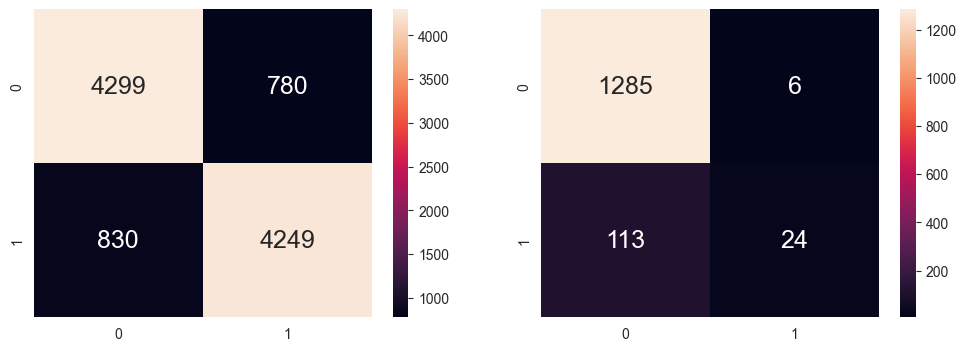

In [113]:
DTtuning(X_train_tech,y_train_tech, X_test_tech, y_test_tech)

## Random Forest
#### Sales & Marketing

In [115]:
rf = RandomForestClassifier()
start = time.time()
rf.fit(X_train_sales, y_train_sales)
end = time.time()

y_train_pred = rf.predict(X_train_sales)
y_test_pred = rf.predict(X_test_sales)

accuracy = accuracy_score(y_train_sales, y_train_pred)
print("Classification accuracy for train \t:", accuracy)
accuracy = accuracy_score(y_test_sales, y_test_pred)
print("Classification accuracy for test \t:", accuracy)
score = f1_score(y_test_sales, y_test_pred, average='binary')
print("F1-Score \t:", score)
recall = recall_score(y_test_sales, y_test_pred, average='binary')
print("Recall \t:", recall)
print("Time taken \t:", end - start)

Classification accuracy for train 	: 0.83046781287485
Classification accuracy for test 	: 0.9569477434679335
F1-Score 	: 0.5845272206303725
Recall 	: 0.4146341463414634
Time taken 	: 1.1758198738098145


<Axes: >

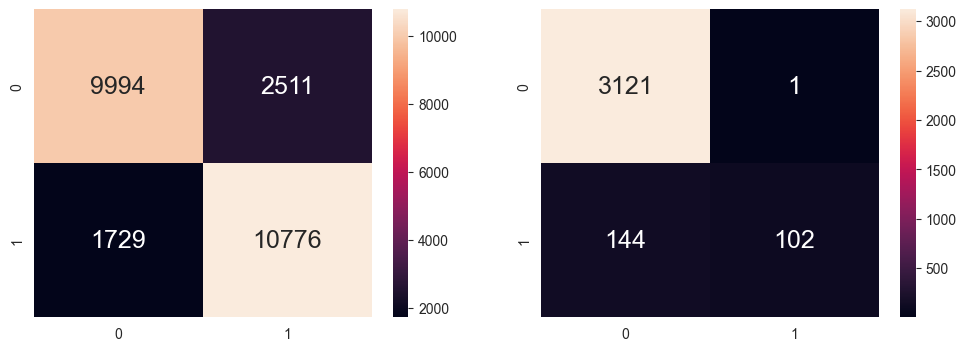

In [116]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_sales, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_sales, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#### Operations

In [118]:
rf = RandomForestClassifier()
start = time.time()
rf.fit(X_train_ops, y_train_ops)
end = time.time()

y_train_pred = rf.predict(X_train_ops)
y_test_pred = rf.predict(X_test_ops)

accuracy = accuracy_score(y_train_ops, y_train_pred)
print("Classification accuracy for train \t:", accuracy)
accuracy = accuracy_score(y_test_ops, y_test_pred)
print("Classification accuracy for test \t:", accuracy)
score = f1_score(y_test_ops, y_test_pred, average='binary')
print("F1-Score \t:", score)
recall = recall_score(y_test_ops, y_test_pred, average='binary')
print("Recall \t:", recall)
print("Time taken \t:", end - start)

Classification accuracy for train 	: 0.820176499032882
Classification accuracy for test 	: 0.9365638766519824
F1-Score 	: 0.5324675324675324
Recall 	: 0.3778801843317972
Time taken 	: 1.0930328369140625


<Axes: >

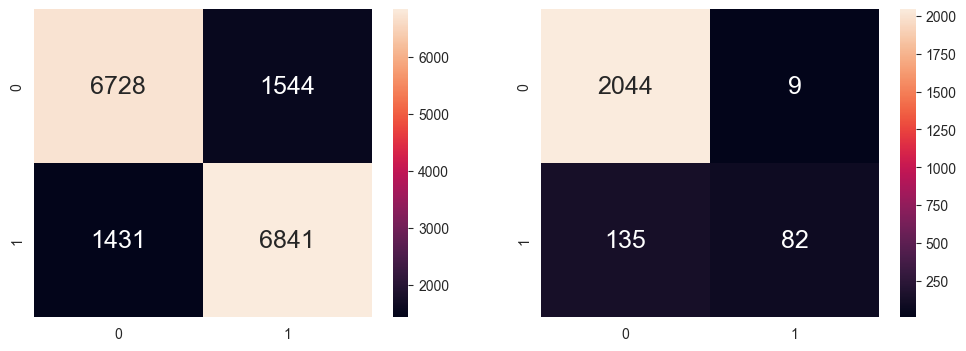

In [119]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_ops, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_ops, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#### Technology

In [121]:
start = time.time()
rf.fit(X_train_tech, y_train_tech)
end = time.time()

y_train_pred = rf.predict(X_train_tech)
y_test_pred = rf.predict(X_test_tech)

accuracy = accuracy_score(y_train_tech, y_train_pred)
print("Classification accuracy for train \t:", accuracy)
accuracy = accuracy_score(y_test_tech, y_test_pred)
print("Classification accuracy for test \t:", accuracy)
score = f1_score(y_test_tech, y_test_pred, average='binary')
print("F1-Score \t:", score)
recall = recall_score(y_test_tech, y_test_pred, average='binary')
print("Recall \t:", recall)
print("Time taken \t:", end - start)

Classification accuracy for train 	: 0.843374680055129
Classification accuracy for test 	: 0.9180672268907563
F1-Score 	: 0.2909090909090909
Recall 	: 0.17518248175182483
Time taken 	: 0.7048389911651611


<Axes: >

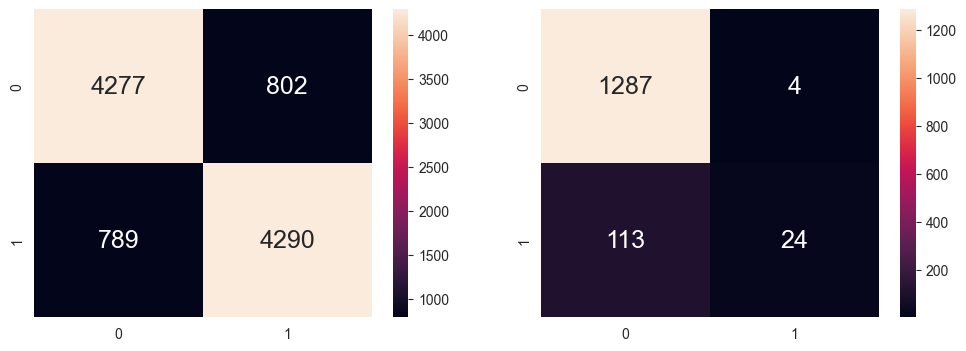

In [122]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_tech, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_tech, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#### Hyperparameter Tuning for Random Forest using RandomizedSearchCV
Using the code below, we try to find the best hyperparameters for each Random Forest to hopefully improve the metrics for each.

In [124]:
from scipy.stats import randint
def RFtuning_random(X_train, y_train, X_test, y_test, n_iter=30):
    rf = RandomForestClassifier()


    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5),
        'criterion': ['gini', 'entropy']
    }

    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,             
        scoring='accuracy',               
        cv=5,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    start = time.time()
    random_search.fit(X_train, y_train)
    end = time.time()
    print("Time taken to search for hyperparameters: \t", end - start)


    print("Best Hyperparameters:", random_search.best_params_)



    y_train_pred = random_search.predict(X_train)
    y_test_pred = random_search.predict(X_test)

    print("Classification Accuracy for train \t:", random_search.score(X_train, y_train))
    print("Classification Accuracy for test \t:", random_search.score(X_test, y_test))
    score = f1_score(y_test, y_test_pred, average='binary')
    print("F1-Score \t:", score)
    recall = recall_score(y_test, y_test_pred, average='binary')
    print("Recall \t:", recall)


    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#### Tuning for Sales & Marketing

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Time taken to search for hyperparameters: 	 80.40399193763733
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 392}
Classification Accuracy for train 	: 0.8272690923630548
Classification Accuracy for test 	: 0.9578384798099763
F1-Score 	: 0.5988700564971752
Recall 	: 0.43089430894308944


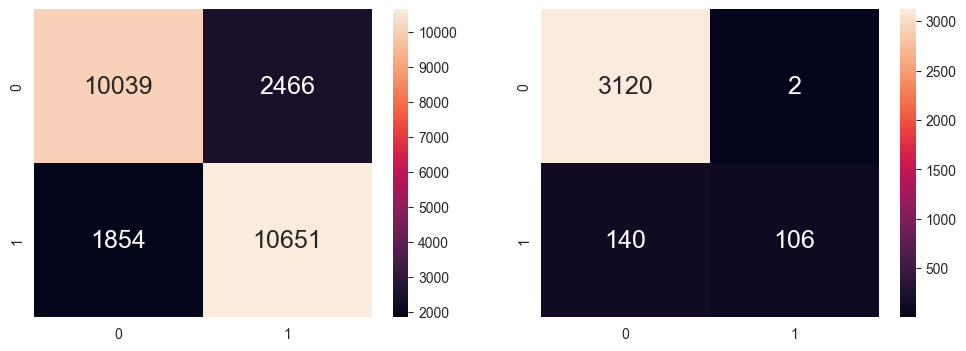

In [126]:
RFtuning_random(X_train_sales,y_train_sales, X_test_sales, y_test_sales)

#### Tuning for Operations

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Time taken to search for hyperparameters: 	 58.83632135391235
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 314}
Classification Accuracy for train 	: 0.8177587040618955
Classification Accuracy for test 	: 0.9444933920704845
F1-Score 	: 0.5909090909090909
Recall 	: 0.41935483870967744


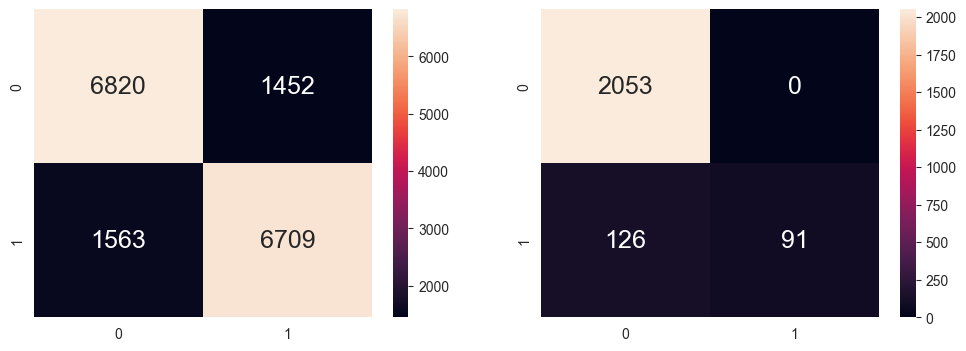

In [128]:
RFtuning_random(X_train_ops,y_train_ops, X_test_ops, y_test_ops)

#### Tuning for Technology

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Time taken to search for hyperparameters: 	 44.629849433898926
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 413}
Classification Accuracy for train 	: 0.843374680055129
Classification Accuracy for test 	: 0.9201680672268907
F1-Score 	: 0.3048780487804878
Recall 	: 0.18248175182481752


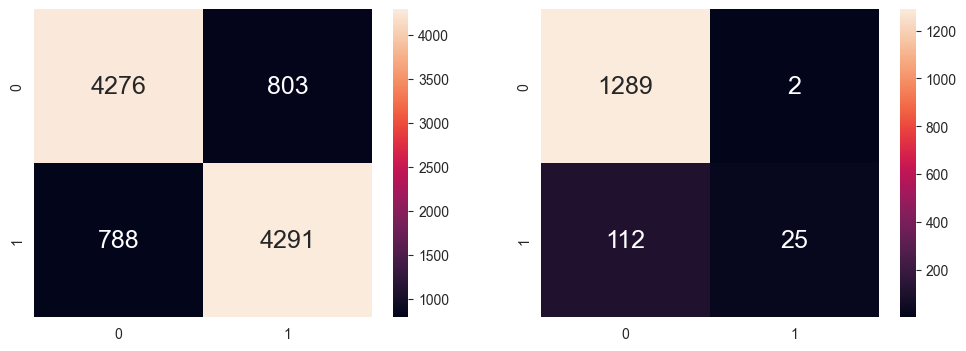

In [130]:
RFtuning_random(X_train_tech,y_train_tech, X_test_tech, y_test_tech)

## CatBoost
CatBoost can automatically handle categorical values without any encoding needed by specifying which columns are categorical. Thus we use the original dataset without any encoding.
#### Sales & Marketing

In [132]:
clf = CatBoostClassifier()

start = time.time()
clf.fit(X_train_sales1, y_train_sales1, 
        cat_features=cat_cols, 
        eval_set=(X_test_sales1, y_test_sales1), 
        verbose=False
)
end = time.time()

print('Fitted: ' + str(clf.is_fitted()))

y_train_pred = clf.predict(X_train_sales1)
y_test_pred = clf.predict(X_test_sales1)

train_score = clf.score(X_train_sales1, y_train_sales1) 
print("Classification accuracy for train:", train_score)
test_score = clf.score(X_test_sales1, y_test_sales1) 
print("Classification accuracy for test:", test_score)
score = f1_score(y_test_sales1, y_test_pred, average='binary')
print("F1-Score \t:", score)
recall = recall_score(y_test_sales1, y_test_pred, average='binary')
print("Recall \t:", recall)
print('Time taken \t:',end - start)

Fitted: True
Classification accuracy for train: 0.810875649740104
Classification accuracy for test: 0.7568289786223278
F1-Score 	: 0.2884448305821025
Recall 	: 0.6747967479674797
Time taken 	: 56.9407913684845


<Axes: >

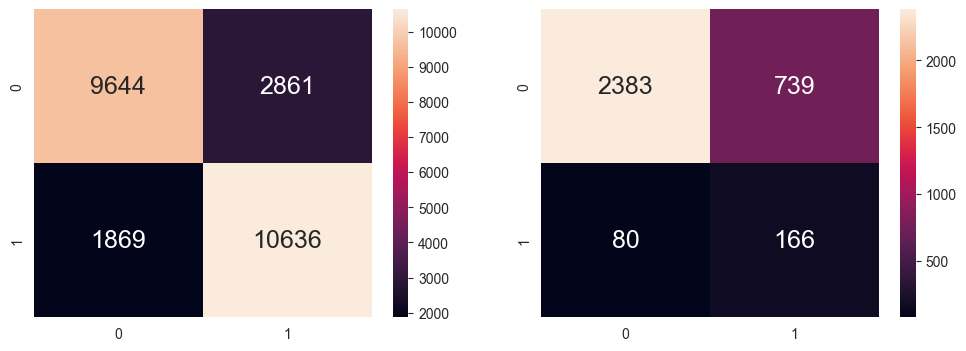

In [133]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_sales1, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_sales1, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#### Operations

In [135]:
clf = CatBoostClassifier()

start = time.time()
clf.fit(X_train_ops1, y_train_ops1, 
        cat_features=cat_cols, 
        eval_set=(X_test_ops1, y_test_ops1), 
        verbose=False
)
end = time.time()

print('Fitted: ' + str(clf.is_fitted()))

y_train_pred = clf.predict(X_train_ops1)
y_test_pred = clf.predict(X_test_ops1)

train_score = clf.score(X_train_ops1, y_train_ops1) 
print("Classification accuracy for train:", train_score)
test_score = clf.score(X_test_ops1, y_test_ops1) 
print("Classification accuracy for test:", test_score)
score = f1_score(y_test_ops1, y_test_pred, average='binary')
print("F1-Score \t:", score)
recall = recall_score(y_test_ops1, y_test_pred, average='binary')
print("Recall \t:", recall)
print('Time taken \t:',end - start)

Fitted: True
Classification accuracy for train: 0.8004714700193424
Classification accuracy for test: 0.7801762114537445
F1-Score 	: 0.36594663278271916
Recall 	: 0.663594470046083
Time taken 	: 52.50564908981323


<Axes: >

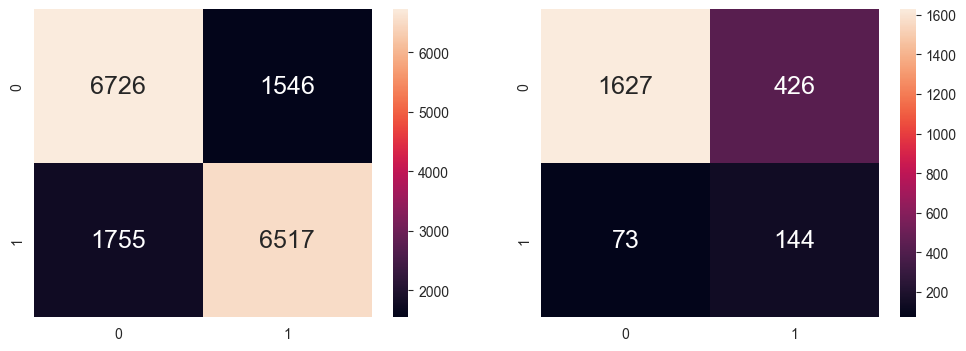

In [136]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_ops1, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_ops1, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

#### Technology

In [138]:
clf = CatBoostClassifier()

start = time.time()
clf.fit(X_train_tech1, y_train_tech1, 
        cat_features=cat_cols, 
        eval_set=(X_test_tech1, y_test_tech1), 
        verbose=False
)
end = time.time()

print('Fitted: ' + str(clf.is_fitted()))

y_train_pred = clf.predict(X_train_tech1)
y_test_pred = clf.predict(X_test_tech1)

train_score = clf.score(X_train_tech1, y_train_tech1) 
print("Classification accuracy for train:", train_score)
test_score = clf.score(X_test_tech1, y_test_tech1) 
print("Classification accuracy for test:", test_score)
score = f1_score(y_test_tech1, y_test_pred, average='binary')
print("F1-Score \t:", score)
recall = recall_score(y_test_tech1, y_test_pred, average='binary')
print("Recall \t:", recall)
print('Time taken \t:',end - start)

Fitted: True
Classification accuracy for train: 0.8174837566450088
Classification accuracy for test: 0.7927170868347339
F1-Score 	: 0.3537117903930131
Recall 	: 0.5912408759124088
Time taken 	: 51.898884773254395


<Axes: >

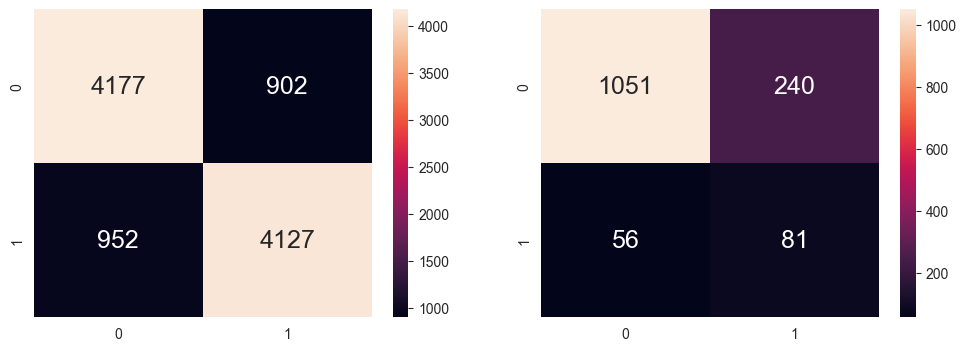

In [139]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train_tech1, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test_tech1, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

## Analysis

Accuracy for all 3 models seem to be decent, with every model having a classification accuracy on the test dataset of above 75%. \
However the F1-Score does not seem to be ideal for each model, where the score can be as low as 0.28.

#### Comparing all 3 models 
CatBoost seems to be the worst-performing model, with a lower classification accuracy of 75% to 79% on the test dataset. \
CatBoost also takes the most amount of time, ranging from 51 seconds to 57 seconds. \
The F1-Score also tends to be lesser than 0.37. \
However, it should be noted that CatBoost can automatically handle categorical data without any encoding needed, making it more convenient. 

#### Comparing the Decision Tree and Random Forest models 
They provide similar statistics, with accuracy generally being above 90% on the test dataset and the F1-Score ranging from about 0.29 to 0.59 \
Although classification accuracy is high, the F1-Score seems to be rather low, especially for the models for the Technology department. \
Although Random Forest takes a longer time to fit the dataset than the Decision Tree models, it only takes about at most 1.2 seconds longer. \

#### Comparing the models between each department 
The model for the Technology department seems to have the worst metrics for both Decision Trees and Random Forest, which may be due to the lower number of training data compared to the models for the Sales & Marketing and Operations departments. \
However, one interesting thing is that CatBoost has better metrics for the Technology department as compared to the Sales & Marketing department, which is in contrast to the Decision Trees and Random Forest where the Sales & Marketing model has the best metrics. This may indicate that hyperparameter tuning may be needed for CatBoost to perform better. \
It may not be realistic to make models for each department, especially as the number of people in each department gets smaller. As shown by the EDA, the general predictors seem to be the same across departments, thus it may be possible to create a model for all departments. 

#### Assessing the impact of hyperparameter tuning
It can be seen that for a vast majority of the Decision Tree and Random Forest models, hyperparameter tuning was able to improve metrics or at least maintain similar metrics such as classification accuracy and F1-Score. For example, the Decision Tree model for the Operations department, classification accuracy for the test dataset increased from 0.936 to 0.941, while F1-Score increased from 0.529 to 0.548. \
However, hyperparameter tuning does take longer times, where the tuning can take as long as 80 seconds for a Random Forest model and as long as 12 seconds for a Decision Tree model. \
Upon trying to implement hyperparameter tuning for the CatBoost model, we realised that the time taken exceeded 200 seconds, making it highly infeasible.

### Conclusion
After comparing each of the 3 models, we note that CatBoost seems to perform the worst, with worse metrics than the Decision Tree and Random Forest models while taking a much longer time of 50+ seconds even without hyperparameter tuning. Hyperparameter tuning seems infeasible as it can take up to 200+ seconds. \
Comparing both Decision Trees and Random Forest, although both provide similar metrics, we are in favour of using Decision Trees due to its lower time taken for fitting the model and hyperparameter tuning, making it more ideal especially if one wishes to create separate models for each department. \
However it should be noted that for the Technology department, although accuracy is still above 90%, the F1-Score is still very low at about 0.30. This is because the dataset is highly imbalanced, with a lot of people not being promoted, thus accuracy will still be high even with a low F1-Score. This shows that maybe other models or other techniques such as class weights can be considered instead to improve the F1-Score.

## Learning Outcomes
- Visualising data using mosaic plot when data is imbalanced
- Cramer's V Values to measure association of one categorical variable with another
- SMOTE-NC to oversample data when it is imbalanced
- Target Encoding to encode categorical variables to use in machine learning models
- Random Forest and CatBoost
- Hyperparameter tuning for Decision Trees and Random Forest using GridSearchCV and RandomizedSearchCV
- Different metrics such as F1-Score and Recall

## Extra codes not used

## Contributors
- SunJin: Slides & Presentation
- Raksha: Slides & Presentation
- Marenda: Notebook Coding

## References
- https://medium.com/analytics-vidhya/hello-everyone-4f9400e008dc
- https://medium.com/@manindersingh120996/understanding-categorical-correlations-with-chi-square-test-and-cramers-v-a54fe153b1d6
- https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html
- https://koshurai.medium.com/title-mastering-target-encoding-in-python-a-comprehensive-guide-e495bd83d602
- https://www.datacamp.com/tutorial/random-forests-classifier-python
- https://www.kaggle.com/code/prashant111/catboost-classifier-in-python
- https://medium.com/biased-algorithms/grid-search-for-decision-tree-ababbfb89833
- https://www.analyticsvidhya.com/blog/2022/11/hyperparameter-tuning-using-randomized-search/
- https://medium.com/@maxgrossman10/accuracy-recall-precision-f1-score-with-python-4f2ee97e0d6